1. Importing Required Libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder # for label encoding
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format',  '{:.2f}'.format)

2. Gathering and Observing Data

In [83]:
df = pd.read_csv("Melbourne_housing_FULL.csv")
df_copy = df.copy()
df_copy.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.50,3067.00,2.00,1.00,1.00,126.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,4019.00
2,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.50,3067.00,3.00,2.00,1.00,0.00,NaN,NaN,Yarra City Council,-37.81,145.01,Northern Metropolitan,4019.00
4,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,4019.00


3. Exploratory Data Analysis

In [84]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df_copy)

##################### Shape #####################
(34857, 21)
##################### Types #####################
Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object
##################### Head #####################
       Suburb             Address  Rooms Type      Price Method SellerG       Date  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt         CouncilArea  Lattitude  Longtitude             Regionname  Propertycount
0  Abbotsford       68 Studley St      2    h        NaN

In [85]:
def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations: 34857
Variables: 21
cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0


In [86]:
df_copy.duplicated().sum()

1

In [87]:
df_copy.loc[df_copy.duplicated(keep=False), :]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
15857,Nunawading,1/7 Lilian St,3,t,NaN,SP,Jellis,17/06/2017,15.40,3131.00,3.00,3.00,2.00,405.00,226.00,2000.00,Manningham City Council,-37.83,145.17,Eastern Metropolitan,4973.00
15858,Nunawading,1/7 Lilian St,3,t,NaN,SP,Jellis,17/06/2017,15.40,3131.00,3.00,3.00,2.00,405.00,226.00,2000.00,Manningham City Council,-37.83,145.17,Eastern Metropolitan,4973.00


In [88]:
df_copy.drop_duplicates(inplace= True)

In [89]:
from sklearn.impute import KNNImputer

def impute_with_knn(df, target_column, feature_columns, n_neighbors=2):
    subset_df = df[[target_column] + feature_columns]

    imputer = KNNImputer(n_neighbors=n_neighbors)

    subset_df_imputed = imputer.fit_transform(subset_df)

    df[target_column] = subset_df_imputed[:, 0]

    return df

In [90]:
df_copy = impute_with_knn(df_copy , target_column= 'Bedroom2' , feature_columns= ['Rooms'])
df_copy = impute_with_knn(df_copy , target_column= 'Bathroom' , feature_columns= ['Rooms' , 'Price' , 'Bedroom2'])
df_copy = impute_with_knn(df_copy , target_column= 'Car' , feature_columns= ['Rooms' , 'Price' , 'Bedroom2' , 'Bathroom' , 'Price' , 'Distance'])
df_copy = impute_with_knn(df_copy , target_column= 'BuildingArea' , feature_columns= ['Rooms' , 'Price' , 'Distance', 'Bedroom2' , 'Bathroom' , 'Car', 'Price' , 'Distance', 'Landsize'])
df_copy = impute_with_knn(df_copy , target_column= 'YearBuilt' , feature_columns= ['Price' , 'Distance' , 'Bathroom' , 'Car' ])

df_copy.drop('Landsize' , axis=1 , inplace= True)

In [91]:
for name, group in df_copy.groupby('Suburb'):
    mean_lattitude = group['Lattitude'].mean()
    mean_longtitude = group['Longtitude'].mean()

    mask = (df_copy['Suburb'] == name)

    df_copy.loc[mask, 'Lattitude'] = df_copy.loc[mask, 'Lattitude'].fillna(mean_lattitude)
    df_copy.loc[mask, 'Longtitude'] = df_copy.loc[mask, 'Longtitude'].fillna(mean_longtitude)


for name, group in df_copy.groupby('CouncilArea'):
    mean_lattitude = group['Lattitude'].mean()
    mean_longtitude = group['Longtitude'].mean()

    mask = (df_copy['CouncilArea'] == name)

    df_copy.loc[mask, 'Lattitude'] = df_copy.loc[mask, 'Lattitude'].fillna(mean_lattitude)
    df_copy.loc[mask, 'Longtitude'] = df_copy.loc[mask, 'Longtitude'].fillna(mean_longtitude)

In [92]:
df_copy.dropna(subset=['CouncilArea'] , inplace= True)

In [93]:
df_copy.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price            7609
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
BuildingArea        0
YearBuilt           0
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [94]:
df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%d/%m/%Y')

df_copy['Month'] = df_copy['Date'].dt.month
df_copy['Year'] = df_copy['Date'].dt.year

df_copy.drop(['Date' , 'Address' , 'Postcode'] , axis = 1, inplace= True)

cat_features = ['Suburb' , 'Type' , 'Method' , 'SellerG' , 'Year' , 'Month' , 'CouncilArea' , 'Regionname']
num_features = df_copy.select_dtypes(np.number).columns.tolist()
target_col = 'Price'

for column in cat_features:
    df_copy[column] = df_copy[column].astype('category')

In [96]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df_copy, "Price", col)

      TARGET_MEAN
Type             
h      1203770.82
t       931077.22
u       627929.53


        TARGET_MEAN
Method             
PI       1117883.99
PN              NaN
S        1051479.40
SA        982504.67
SN              NaN
SP        879095.39
SS              NaN
VB       1194342.90
W               NaN


                            TARGET_MEAN
Regionname                             
Eastern Metropolitan         1108723.00
Eastern Victoria              714328.20
Northern Metropolitan         861484.05
Northern Victoria             619051.20
South-Eastern Metropolitan    877682.68
Southern Metropolitan        1395928.33
Western Metropolitan          837615.32
Western Victoria              432606.77




In [97]:
def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations: 34853
Variables: 19
cat_cols: 5
num_cols: 11
cat_but_car: 3
num_but_cat: 0


In [98]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
  if col != "Price":
    target_summary_with_num(df_copy, "Price", col)

             Rooms
Price             
85000.00      1.00
112000.00     1.00
121000.00     1.00
131000.00     4.00
145000.00     2.50
...            ...
7000000.00    4.00
7650000.00    4.00
8000000.00    5.00
9000000.00    3.00
11200000.00   4.00

[2871 rows x 1 columns]


             Distance
Price                
85000.00         6.40
112000.00        8.40
121000.00        1.30
131000.00        8.90
145000.00       10.85
...               ...
7000000.00       6.30
7650000.00       5.30
8000000.00       9.00
9000000.00      18.80
11200000.00     10.50

[2871 rows x 1 columns]


             Bedroom2
Price                
85000.00         1.00
112000.00        1.00
121000.00        1.00
131000.00        4.00
145000.00        2.50
...               ...
7000000.00       3.00
7650000.00       4.00
8000000.00       5.00
9000000.00       3.00
11200000.00      4.00

[2871 rows x 1 columns]


             Bathroom
Price                
85000.00         1.00
112000.00        1.00
121000.00   

In [99]:
def cat_summary(dataframe, col_name):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")


for col in cat_cols:
    cat_summary(df_copy, col)

    Type  Ratio
h  23978  68.80
u   7296  20.93
t   3579  10.27
##########################################
    Method  Ratio
S    19743  56.65
SP    5093  14.61
PI    4850  13.92
VB    3107   8.91
SN    1317   3.78
PN     308   0.88
SA     226   0.65
W      173   0.50
SS      36   0.10
##########################################
                            Regionname  Ratio
Southern Metropolitan            11836  33.96
Northern Metropolitan             9557  27.42
Western Metropolitan              6799  19.51
Eastern Metropolitan              4376  12.56
South-Eastern Metropolitan        1739   4.99
Eastern Victoria                   228   0.65
Northern Victoria                  203   0.58
Western Victoria                   115   0.33
##########################################
    Month  Ratio
11   4386  12.58
9    4128  11.84
10   3900  11.19
5    3416   9.80
6    3174   9.11
3    3094   8.88
7    2958   8.49
8    2888   8.29
2    2642   7.58
12   1927   5.53
4    1520   4.36
1     820

In [100]:
from scipy.stats import zscore

def remove_outliers(dataframe, numeric_cols, sigma=3):

     for col in numeric_cols:
         z_scores = zscore(dataframe[col])
         abs_z_scores = np.abs(z_scores)
         filtered_entries = (abs_z_scores < sigma)
         dataframe = dataframe[filtered_entries]

     return dataframe

df = remove_outliers(df, num_cols, sigma= 3)

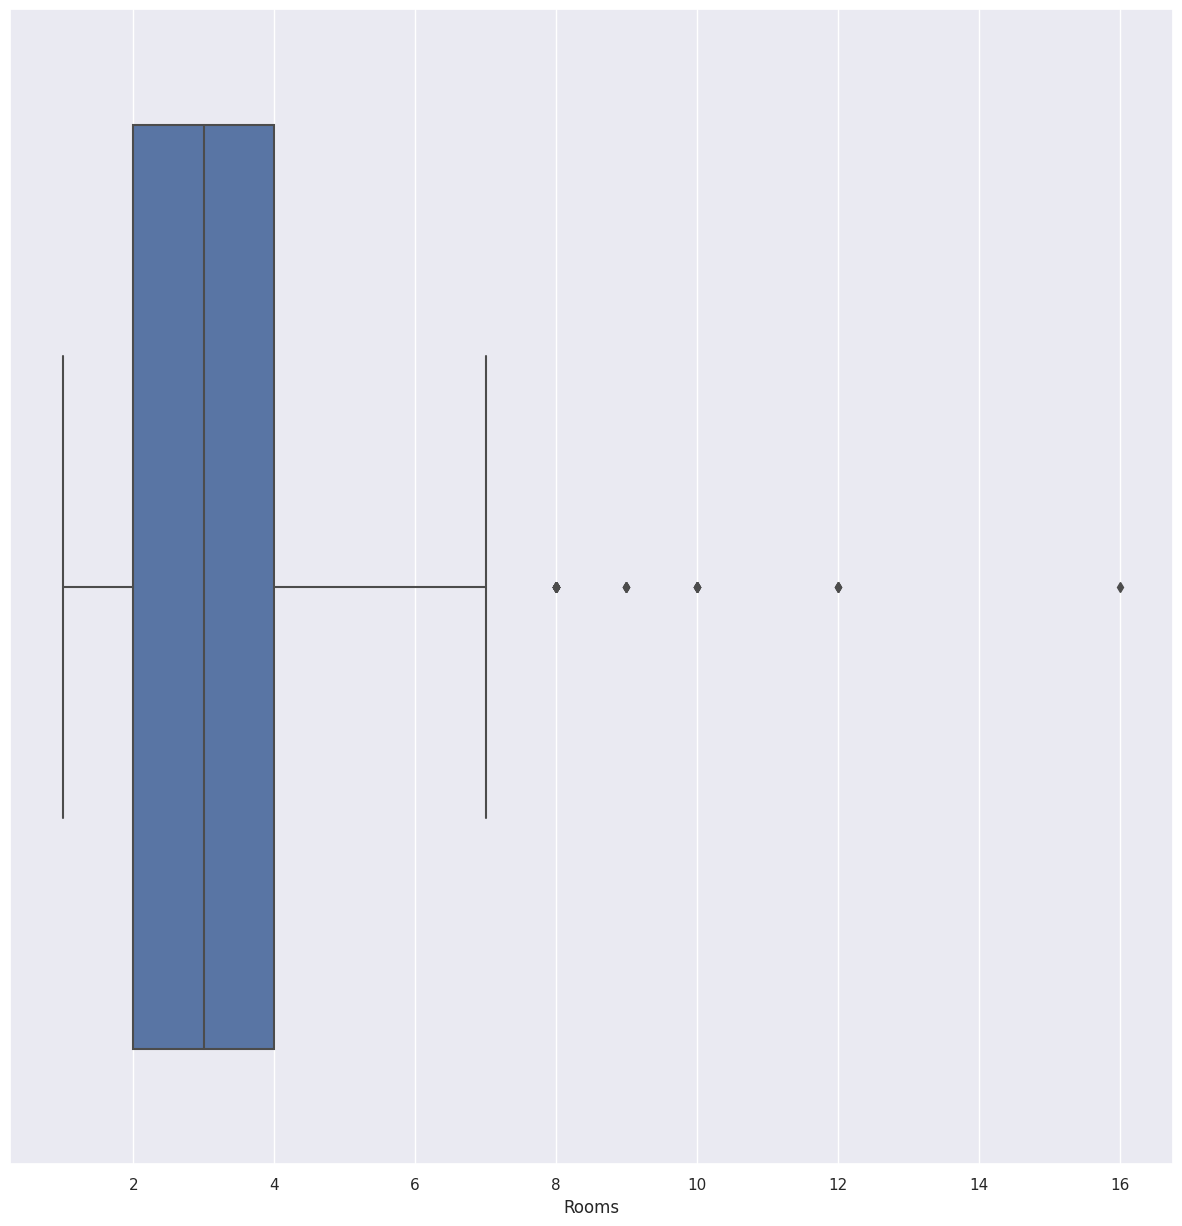

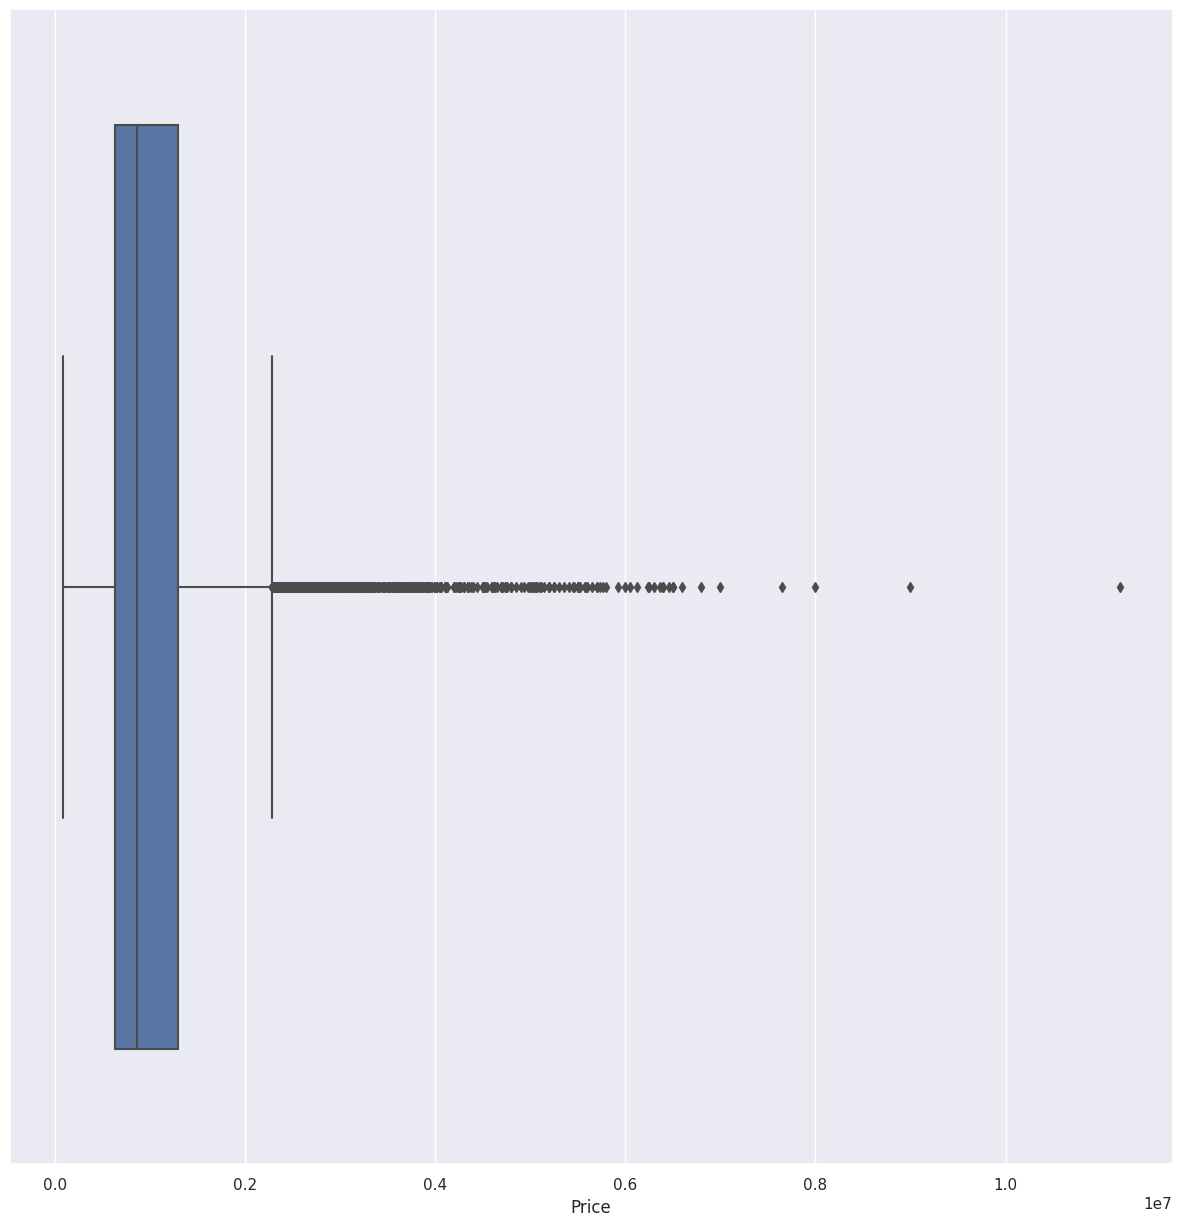

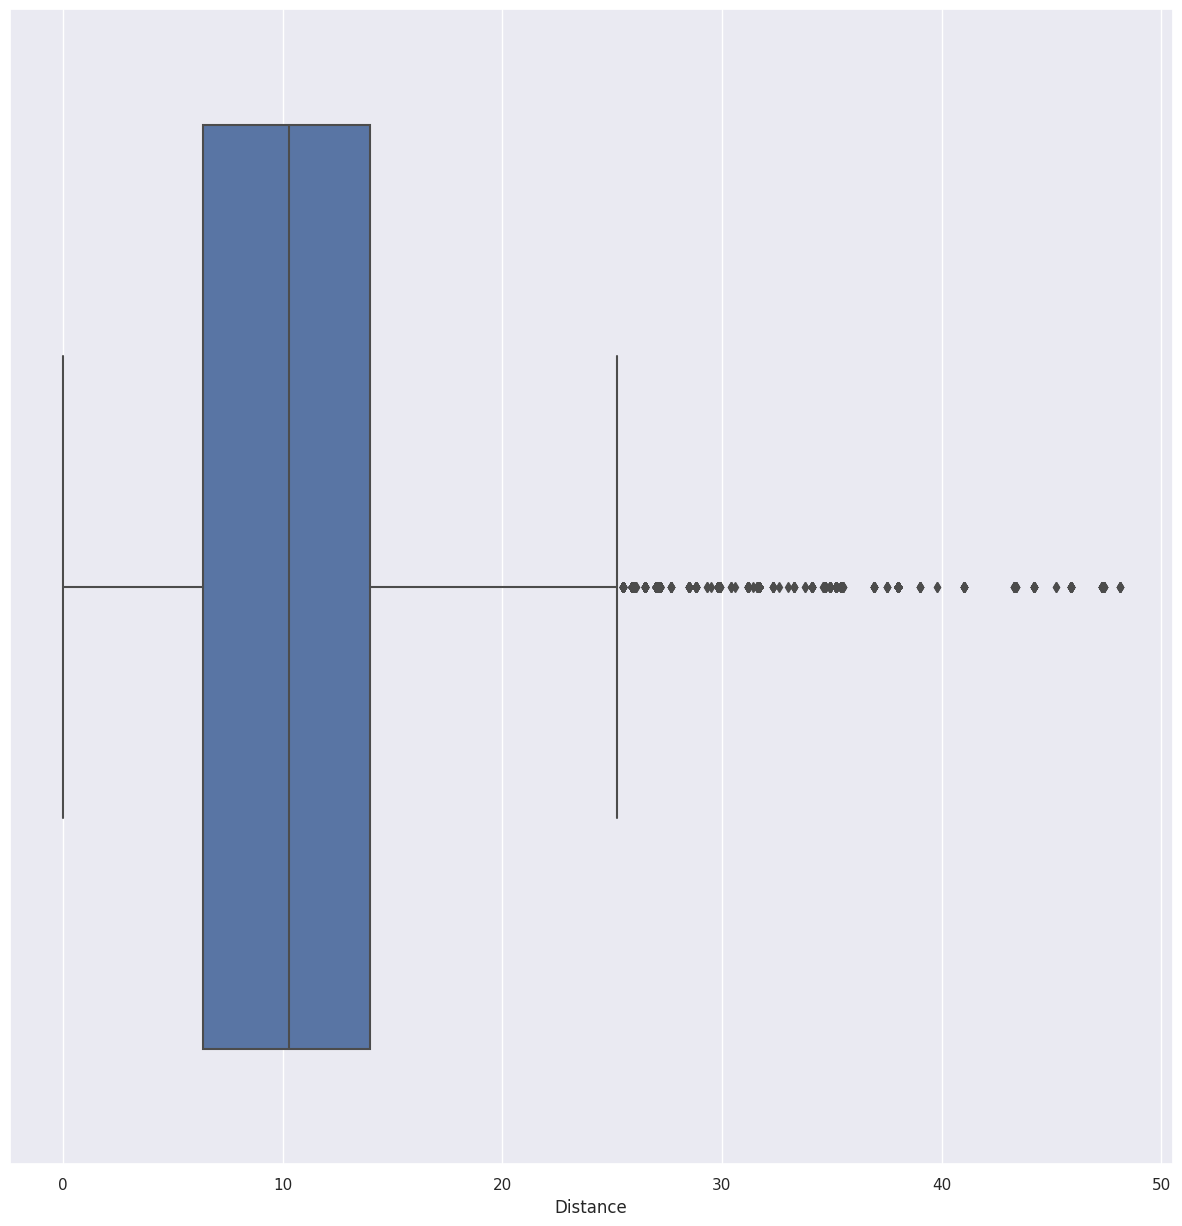

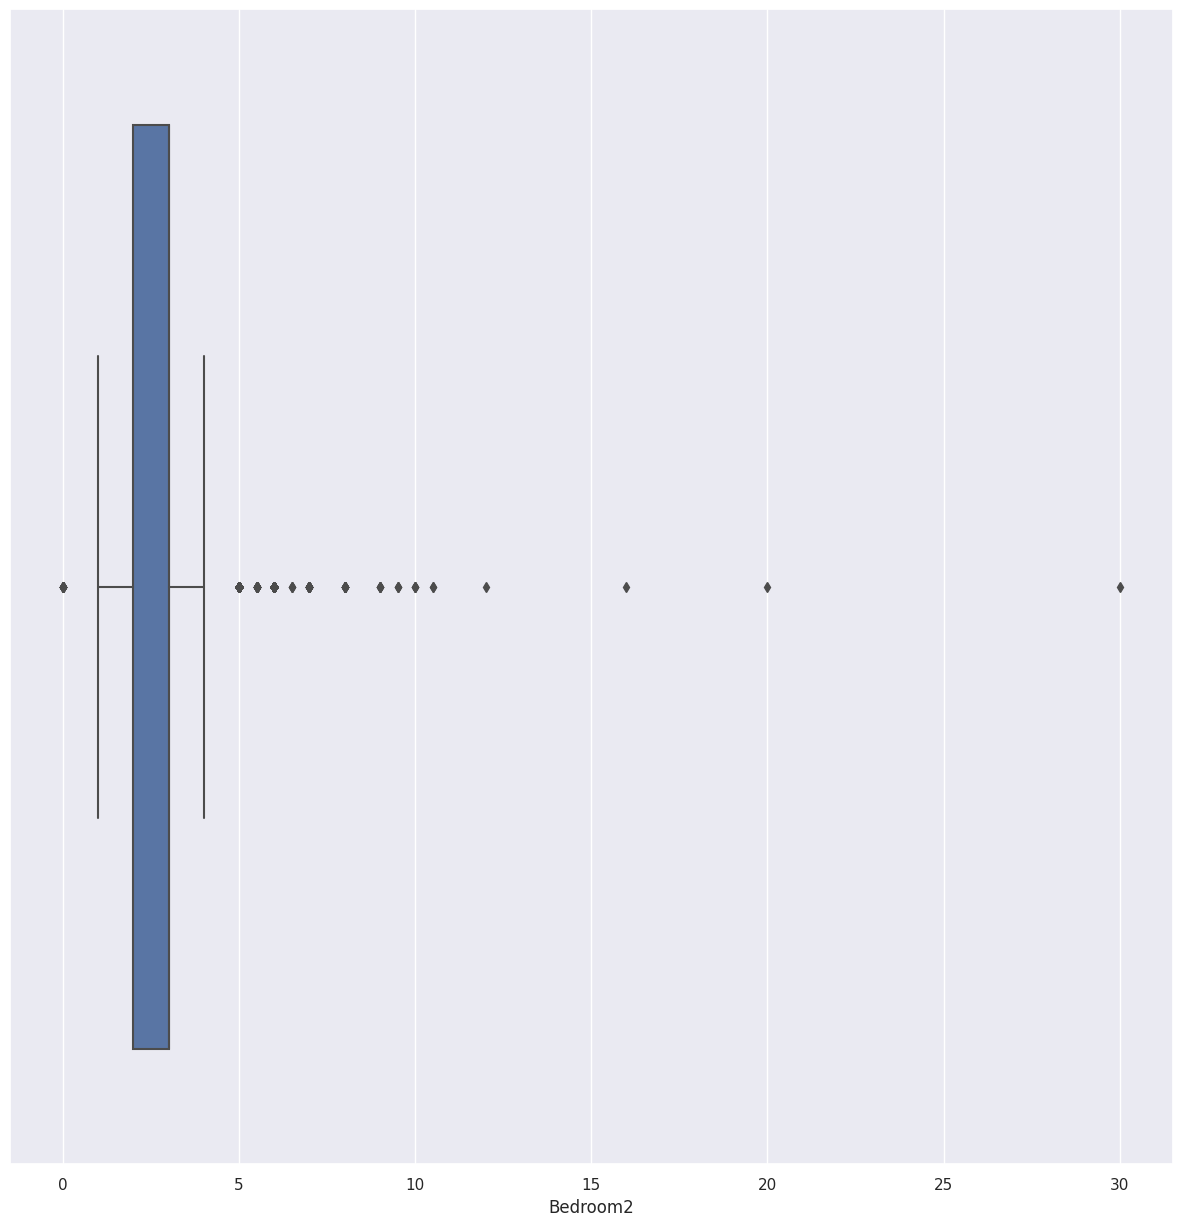

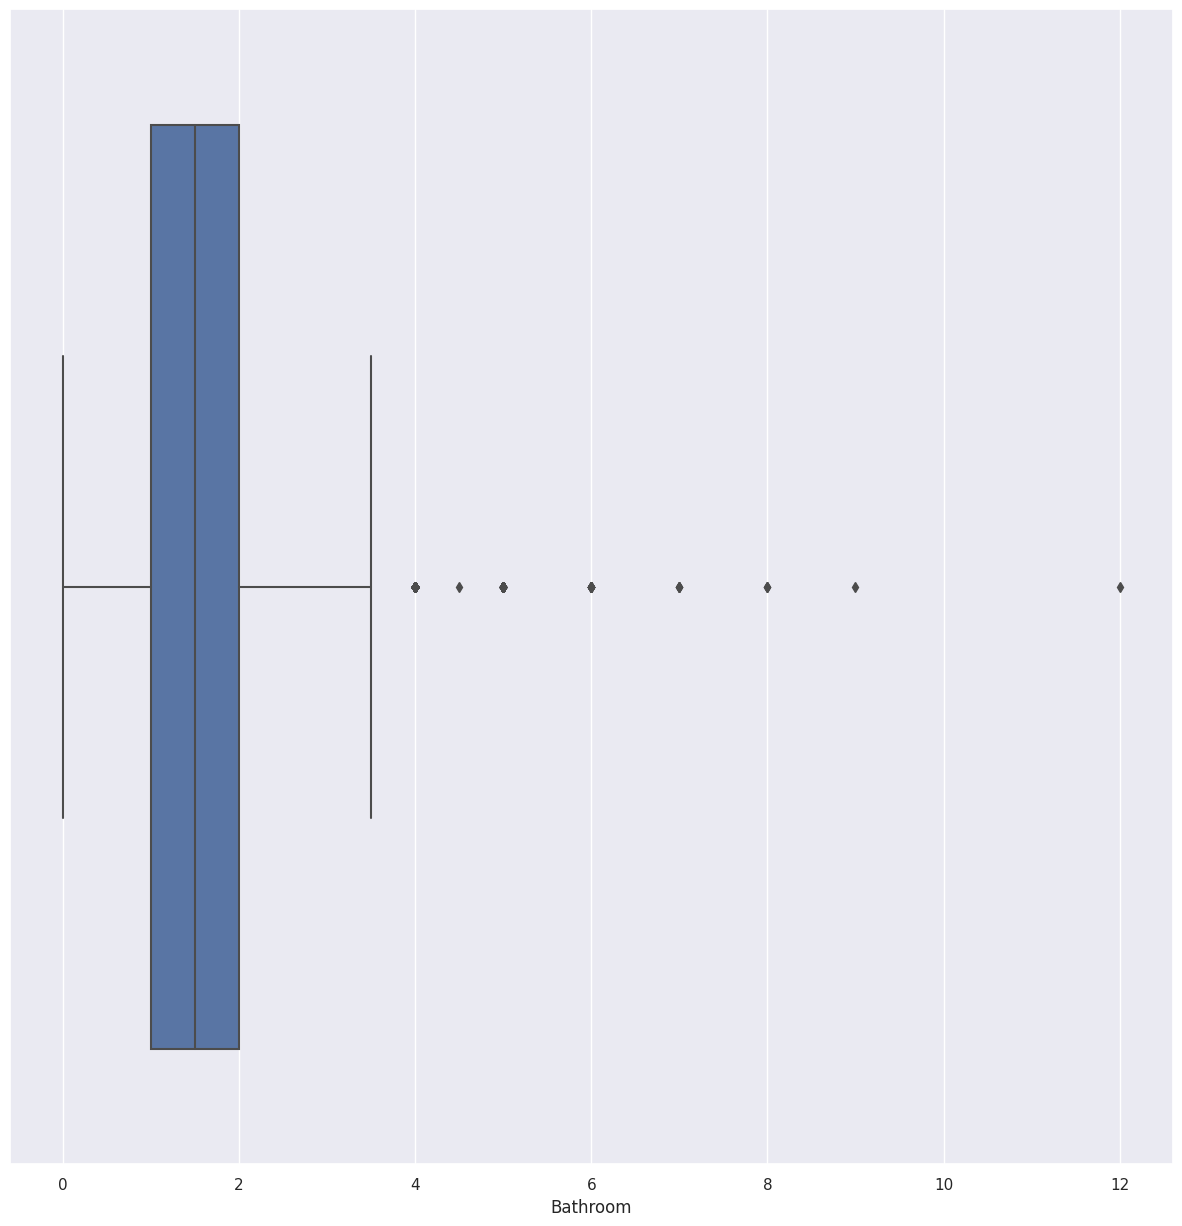

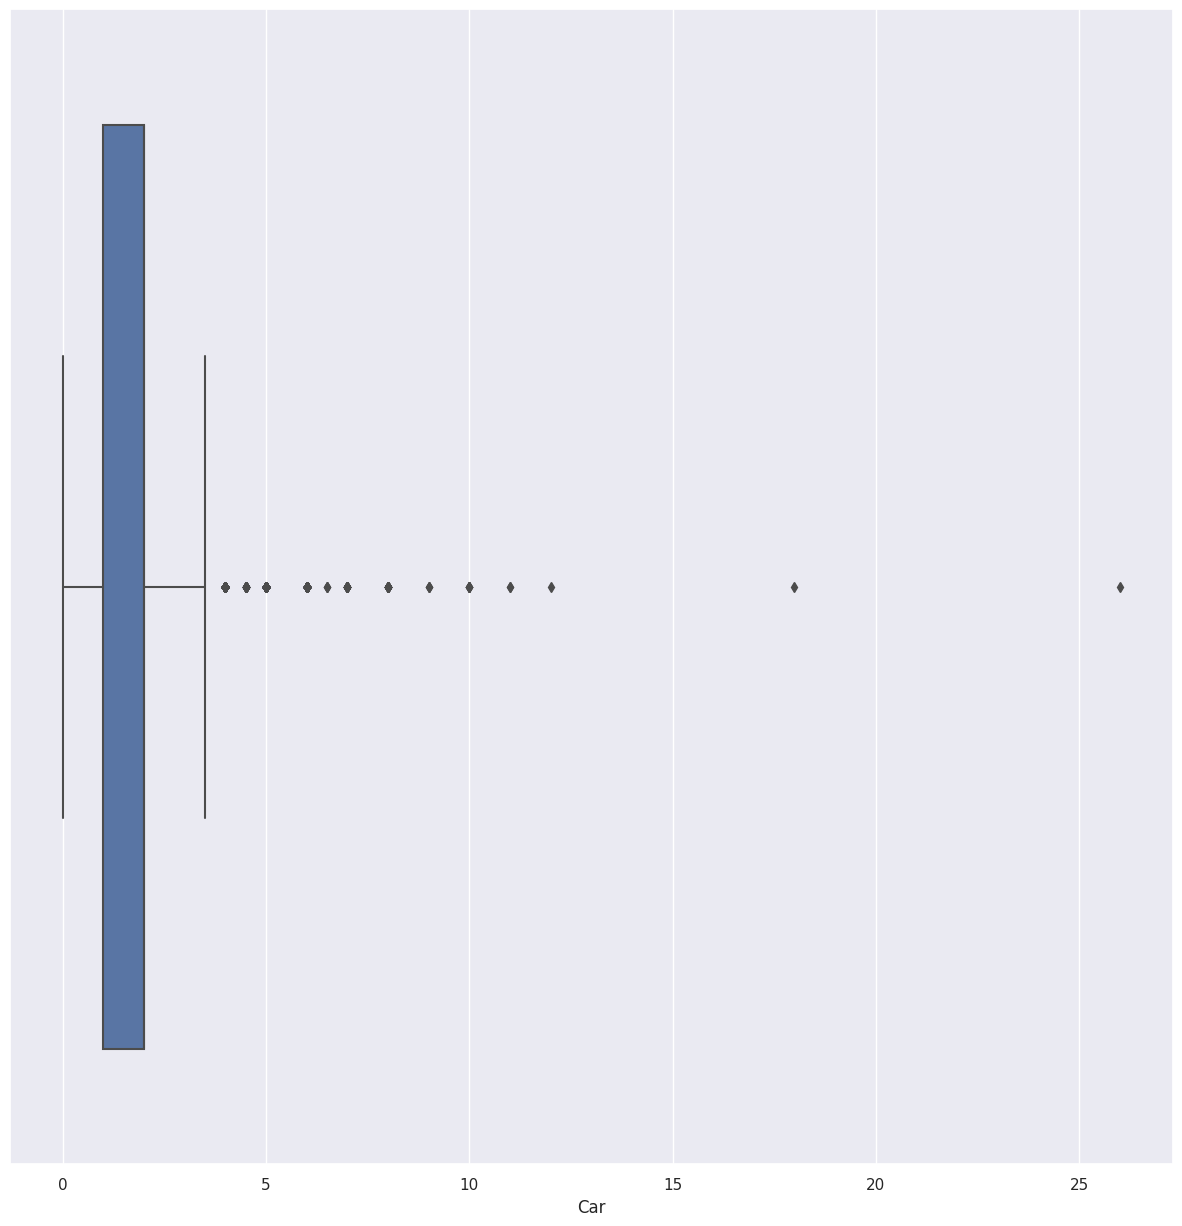

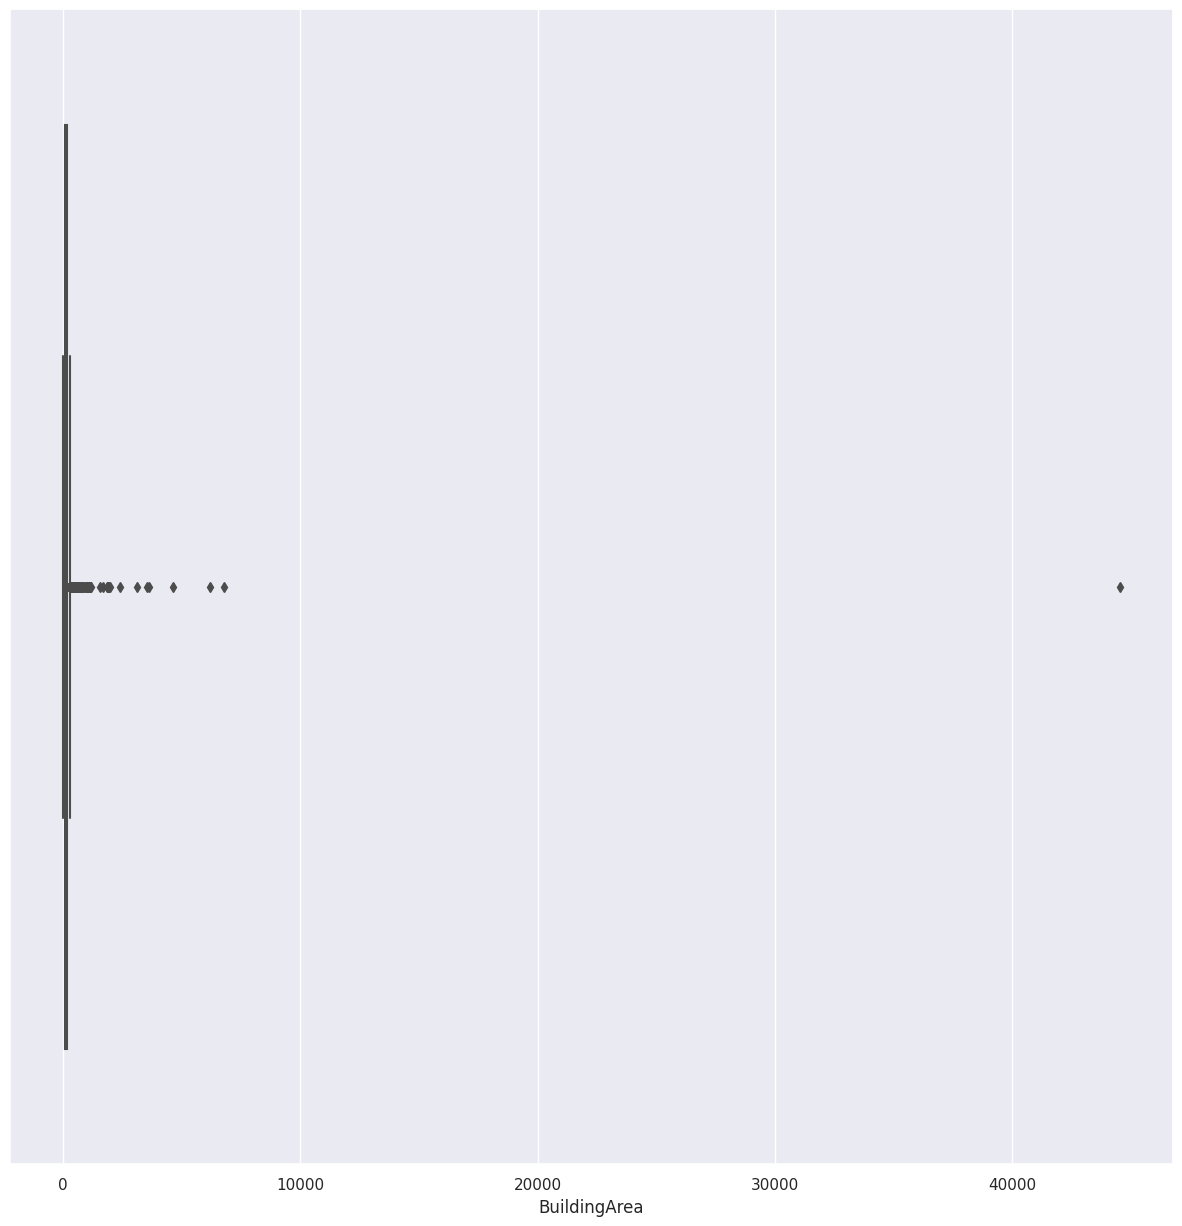

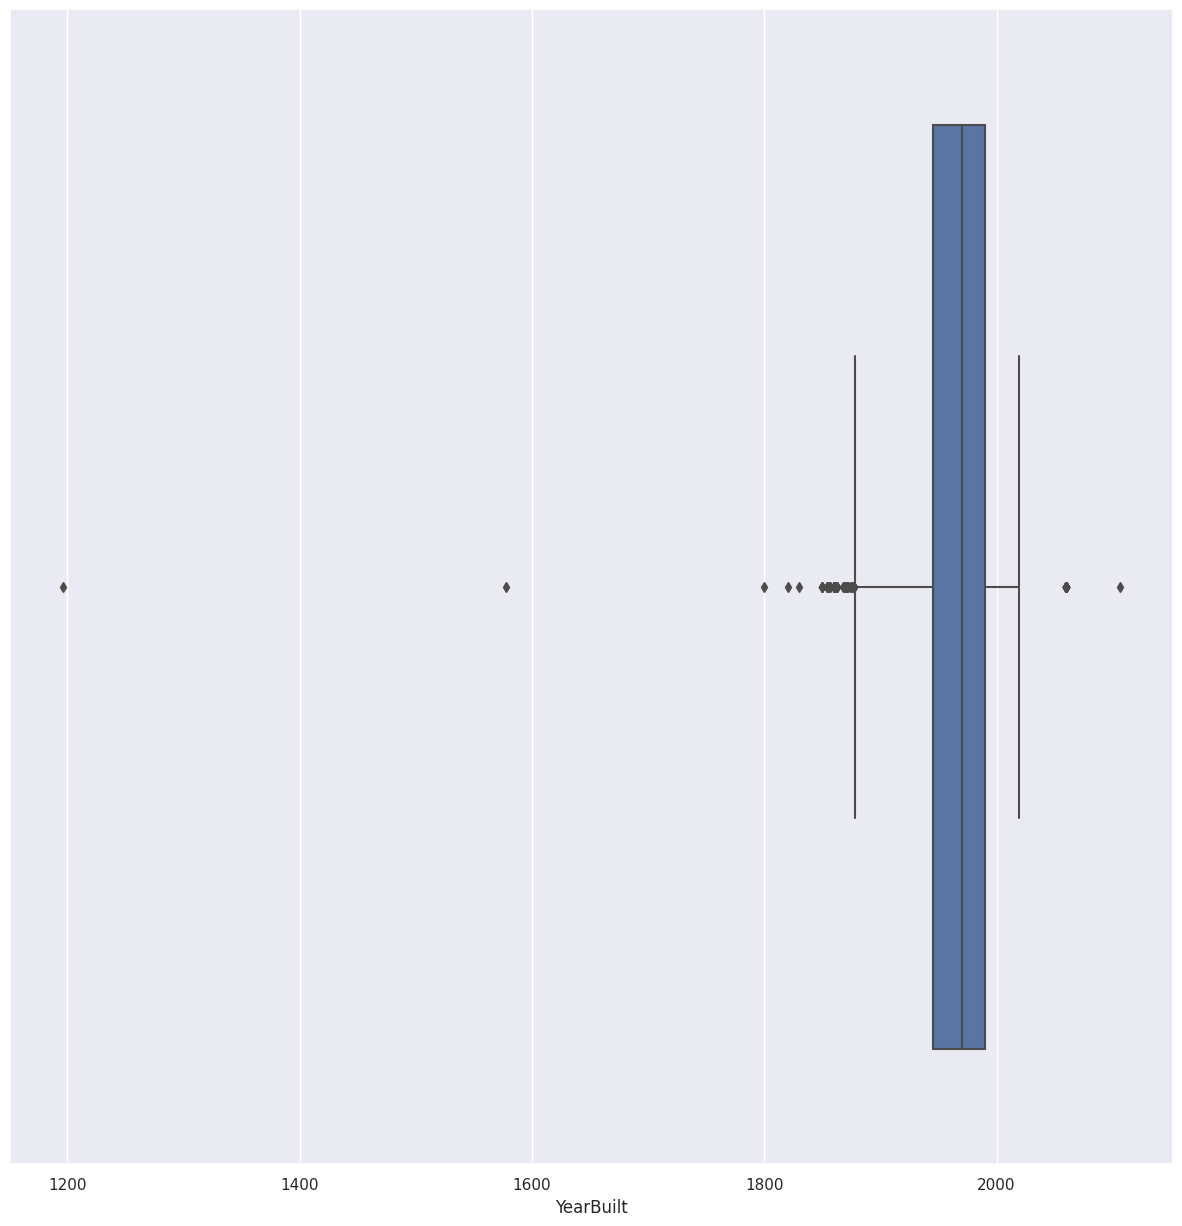

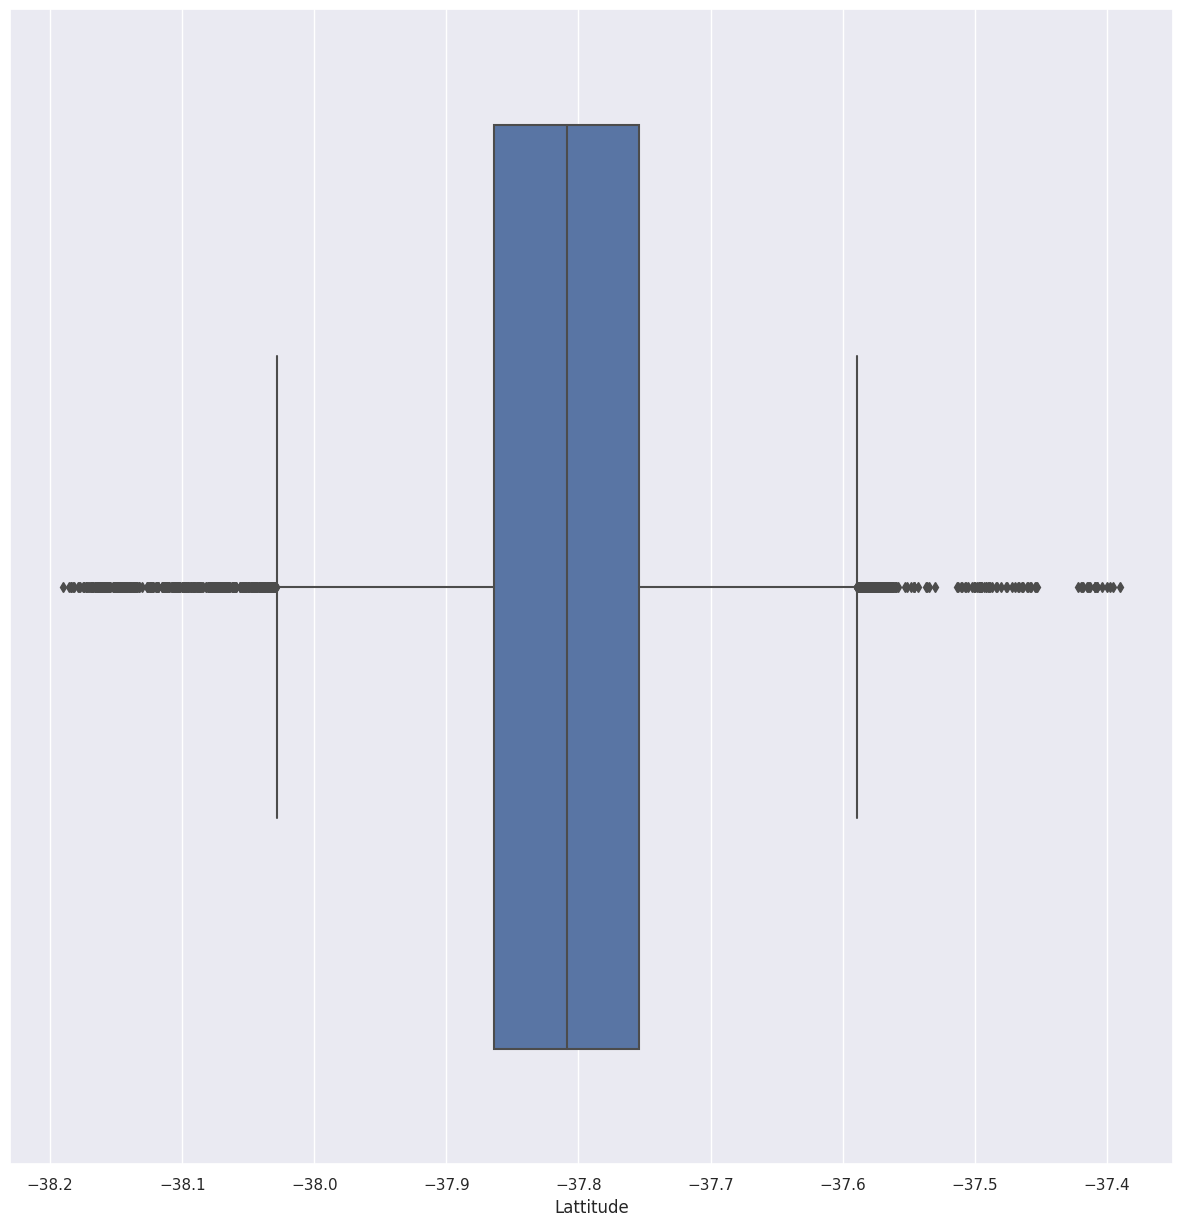

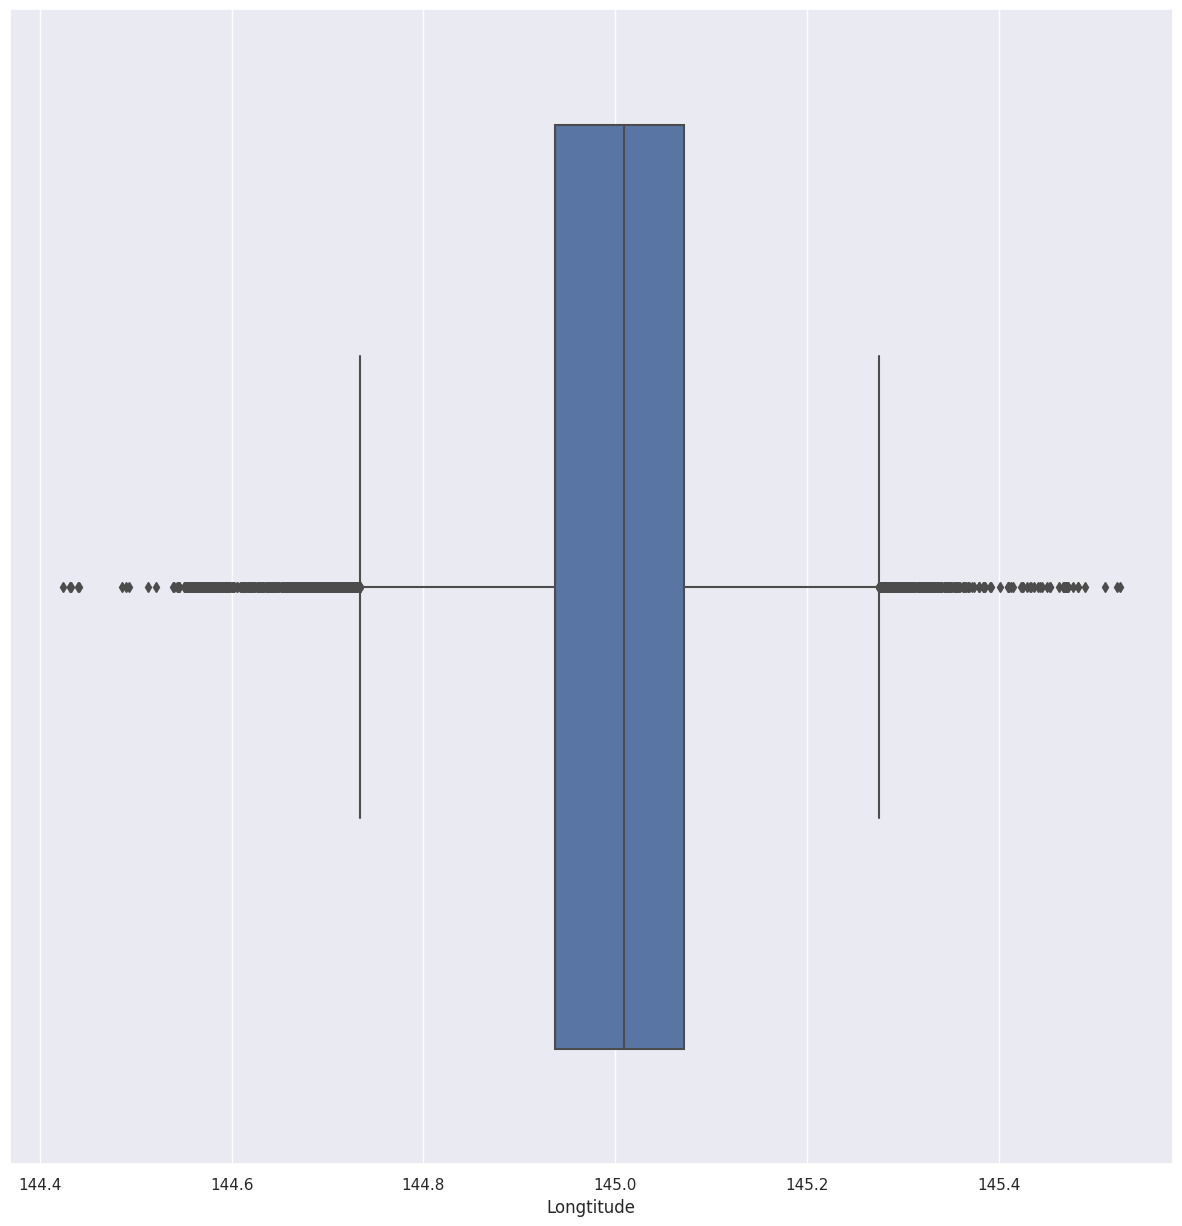

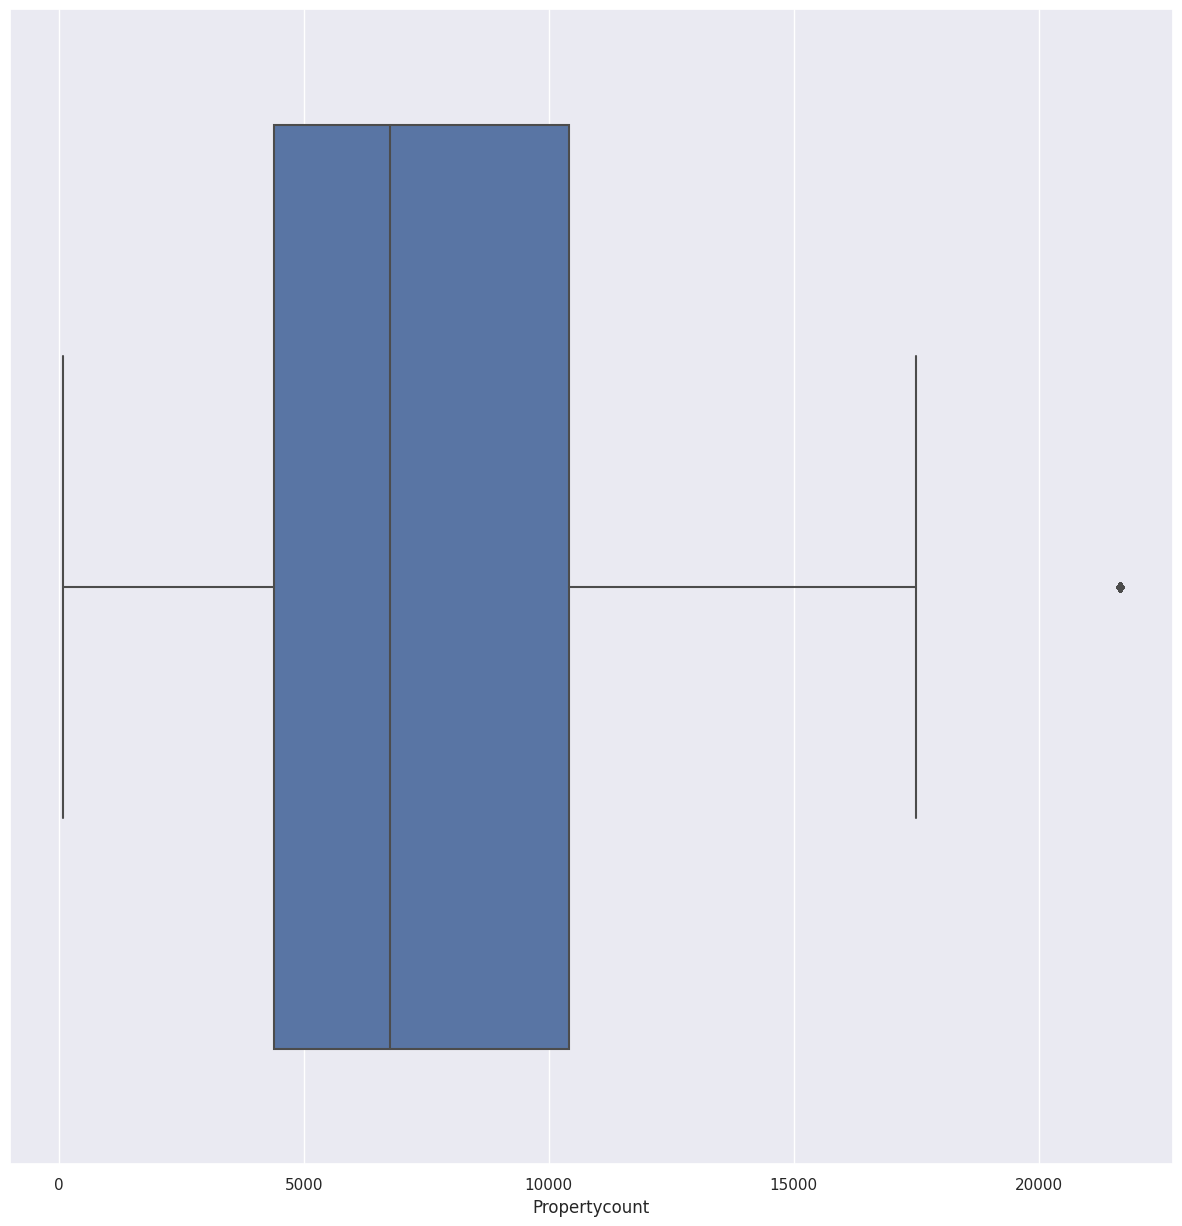

In [101]:
for col in num_cols:
  sns.boxplot(x=df_copy[col])
  plt.show()

<ipython-input-102-0703575ef0fc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataframe.corr()


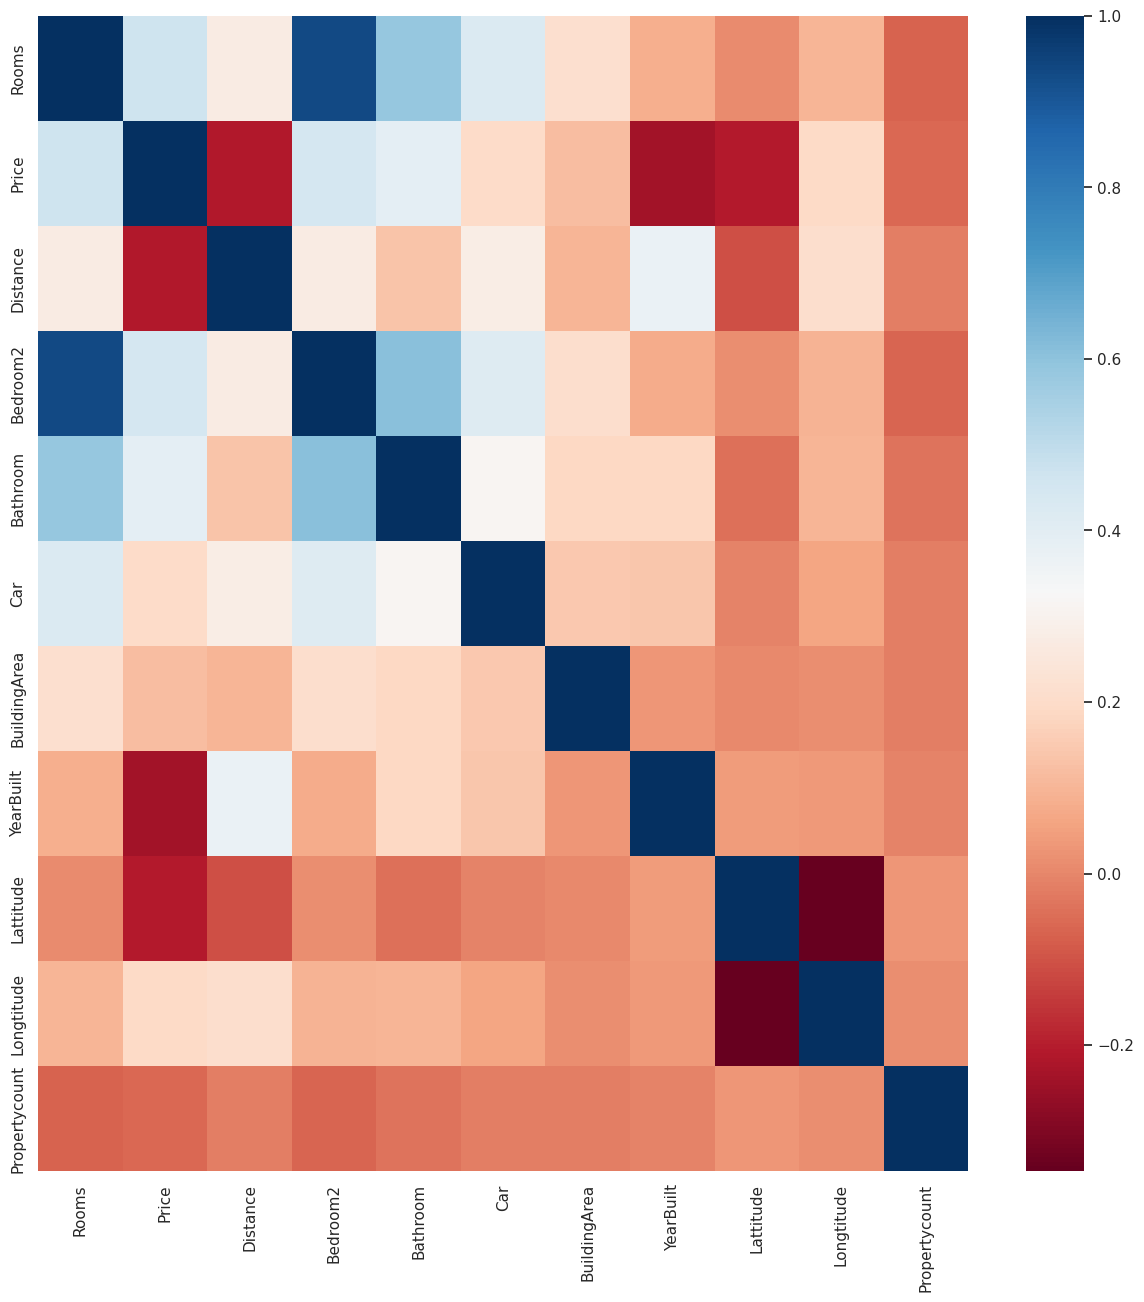

<ipython-input-102-0703575ef0fc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataframe.corr()


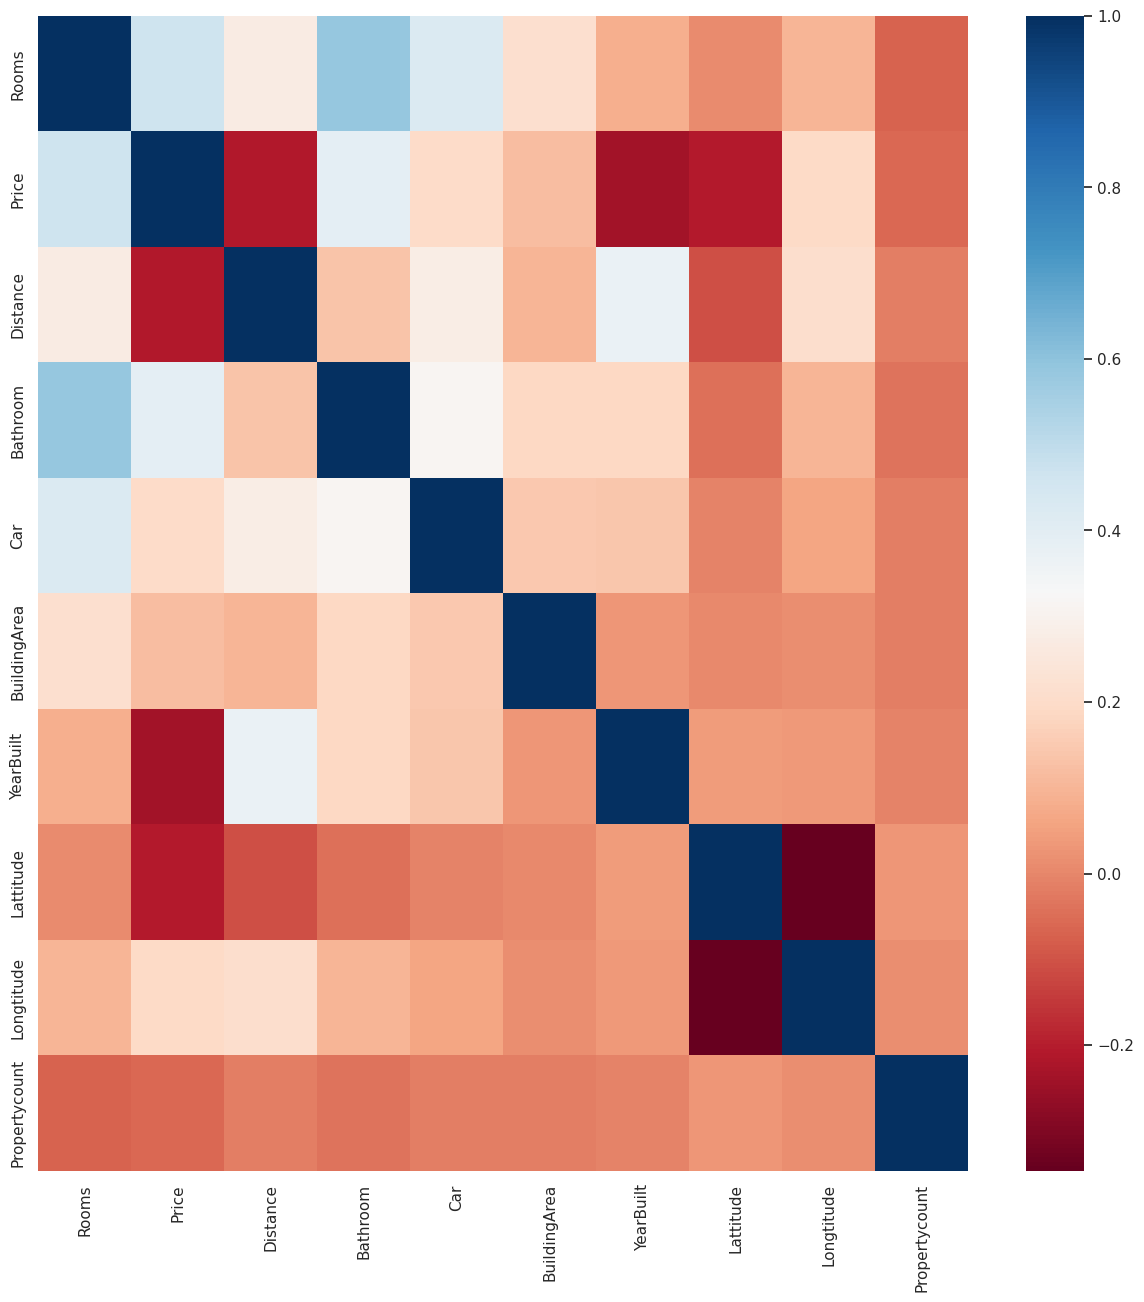

[]

In [102]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

drop_list = high_correlated_cols(df_copy, plot=True)
df_copy.drop(drop_list, axis=1)
high_correlated_cols(df_copy.drop(drop_list, axis=1), plot=True)

Data Visualization

    Type  Ratio
h  23978  68.80
u   7296  20.93
t   3579  10.27


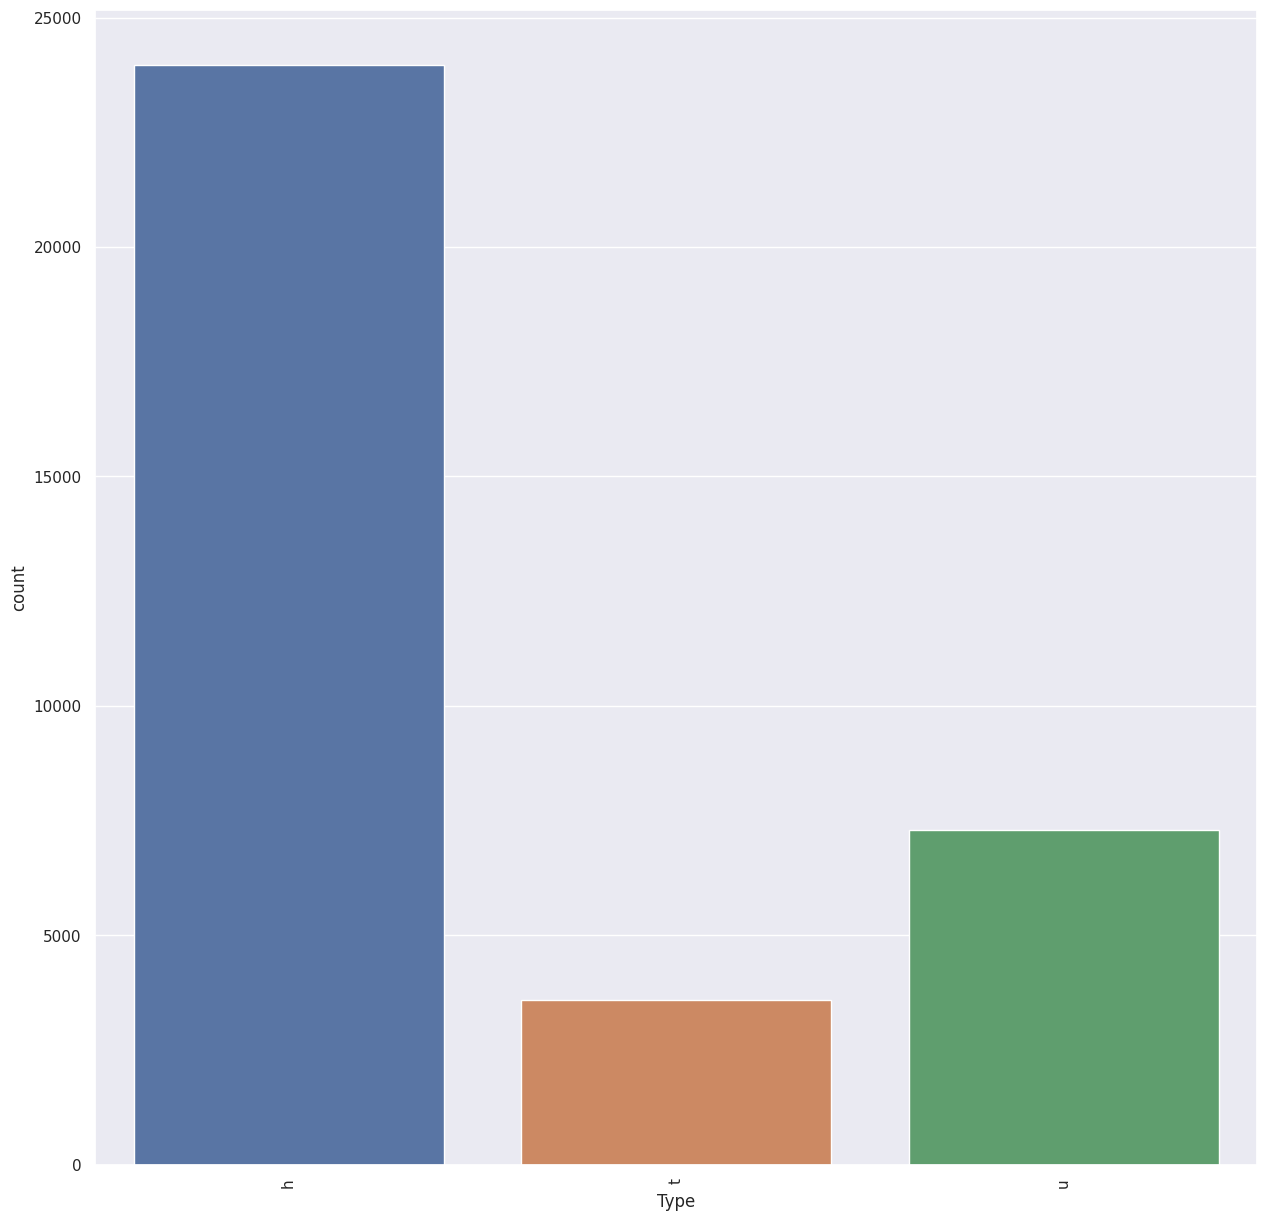

    Method  Ratio
S    19743  56.65
SP    5093  14.61
PI    4850  13.92
VB    3107   8.91
SN    1317   3.78
PN     308   0.88
SA     226   0.65
W      173   0.50
SS      36   0.10


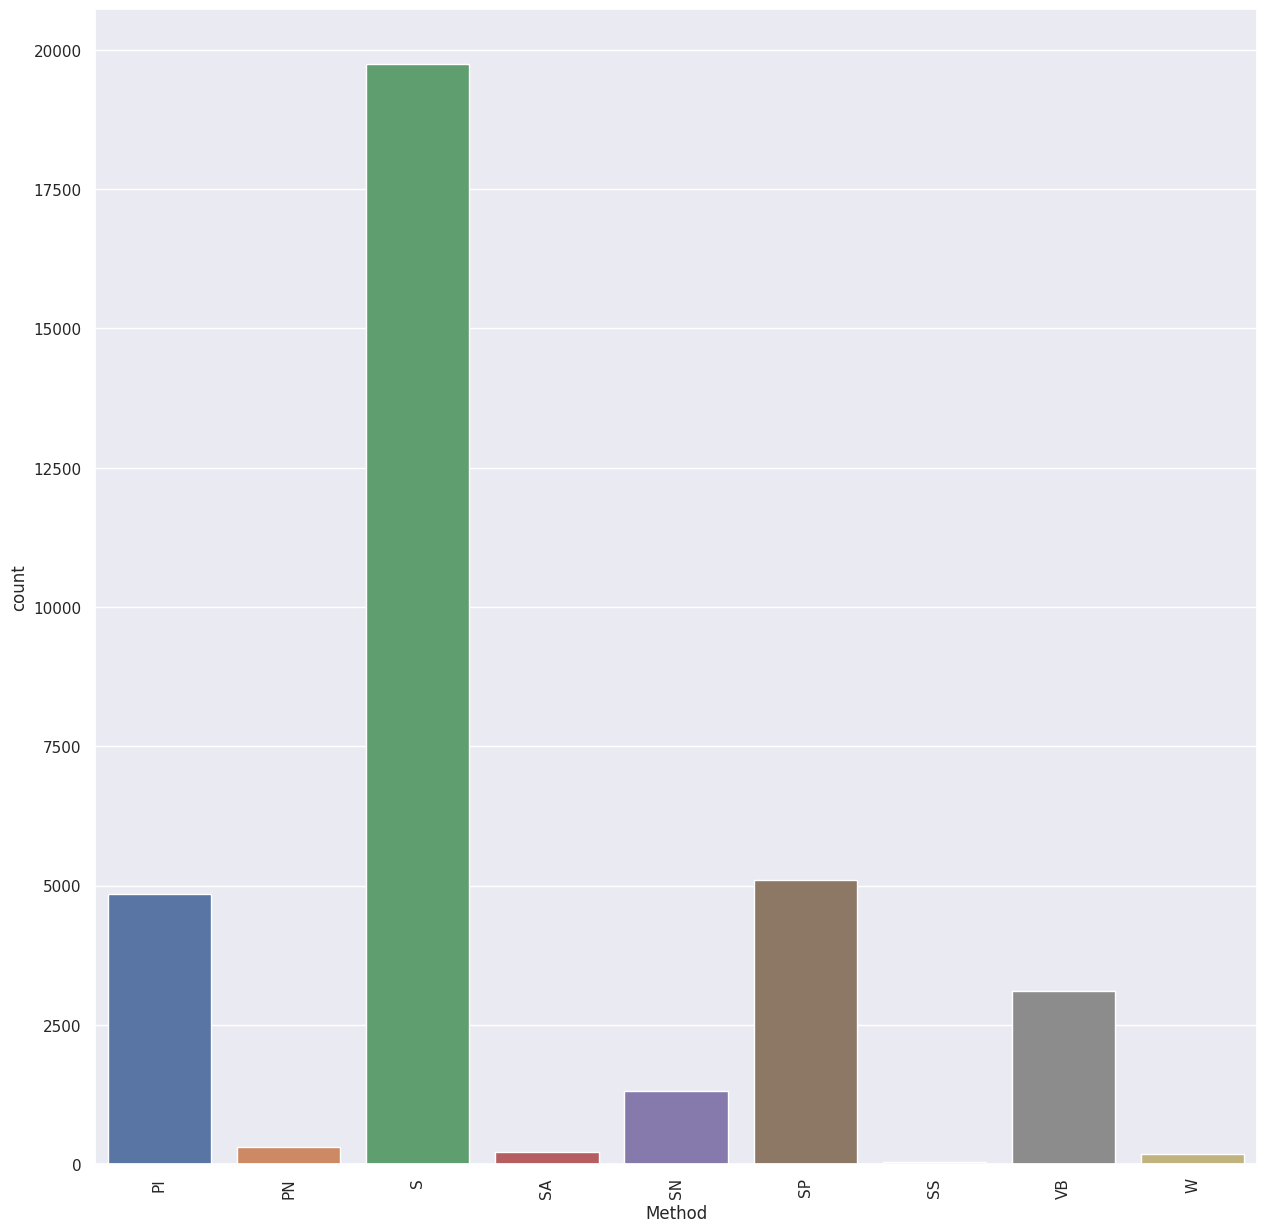

                            Regionname  Ratio
Southern Metropolitan            11836  33.96
Northern Metropolitan             9557  27.42
Western Metropolitan              6799  19.51
Eastern Metropolitan              4376  12.56
South-Eastern Metropolitan        1739   4.99
Eastern Victoria                   228   0.65
Northern Victoria                  203   0.58
Western Victoria                   115   0.33


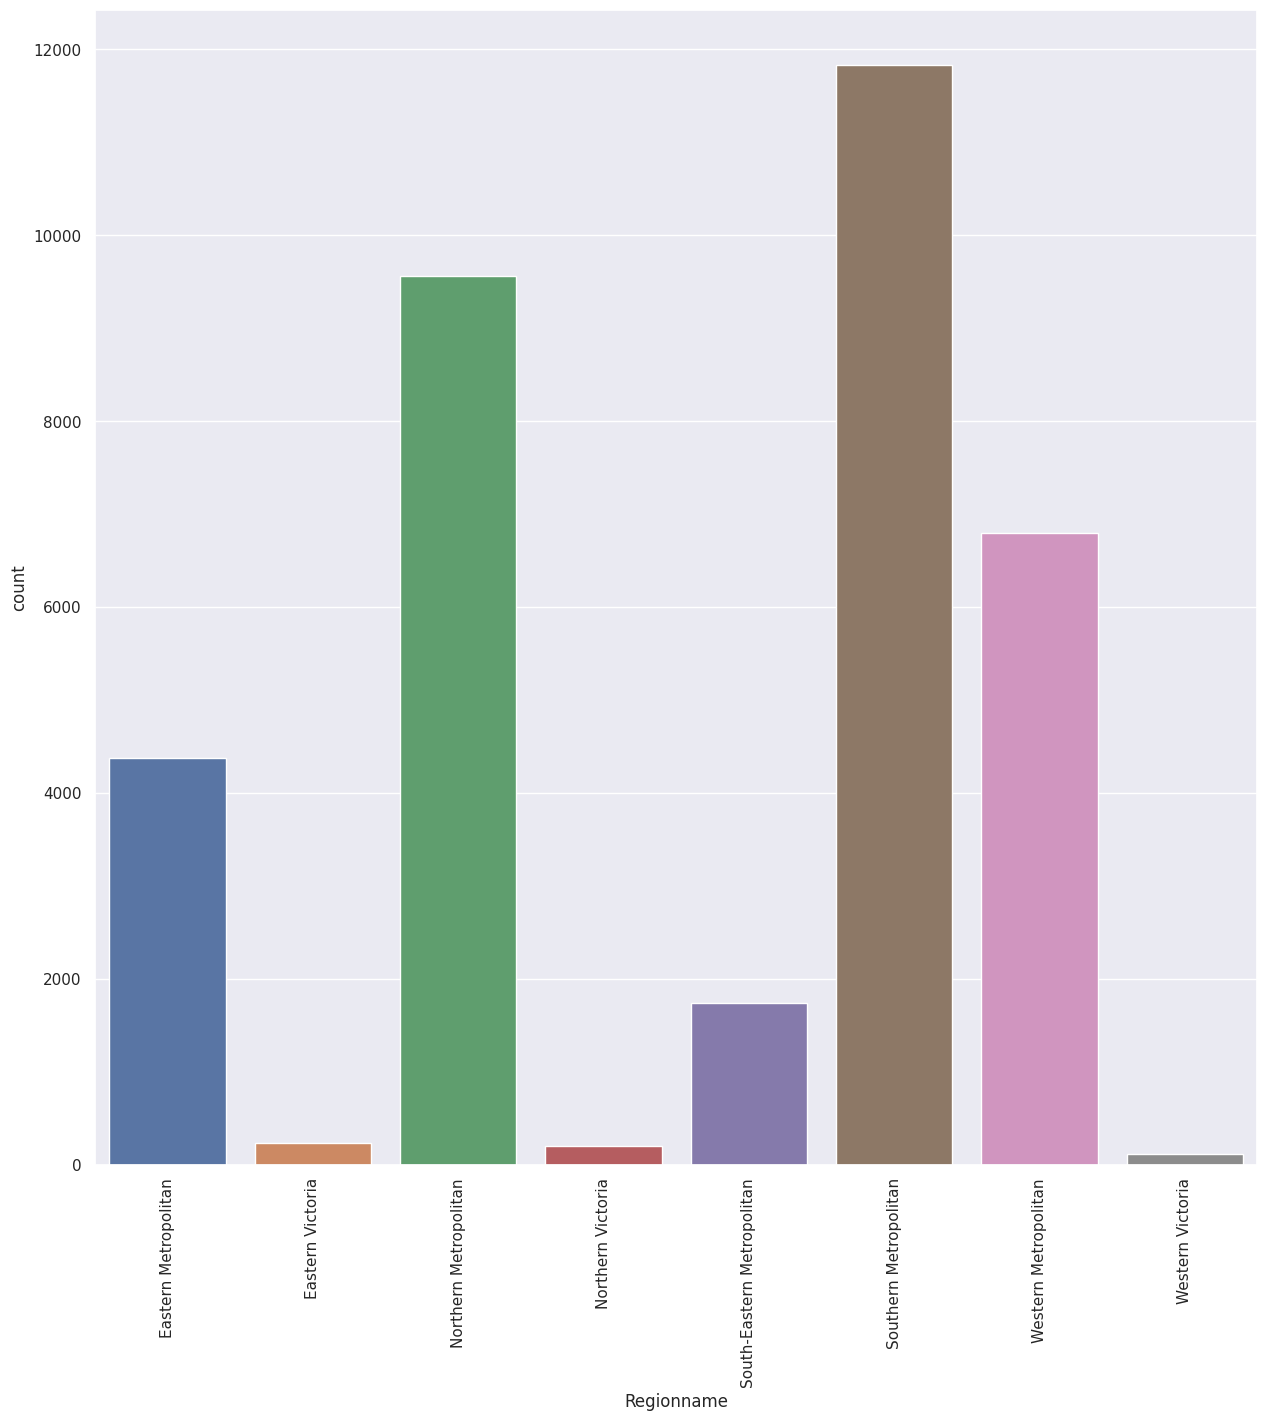

    Month  Ratio
11   4386  12.58
9    4128  11.84
10   3900  11.19
5    3416   9.80
6    3174   9.11
3    3094   8.88
7    2958   8.49
8    2888   8.29
2    2642   7.58
12   1927   5.53
4    1520   4.36
1     820   2.35


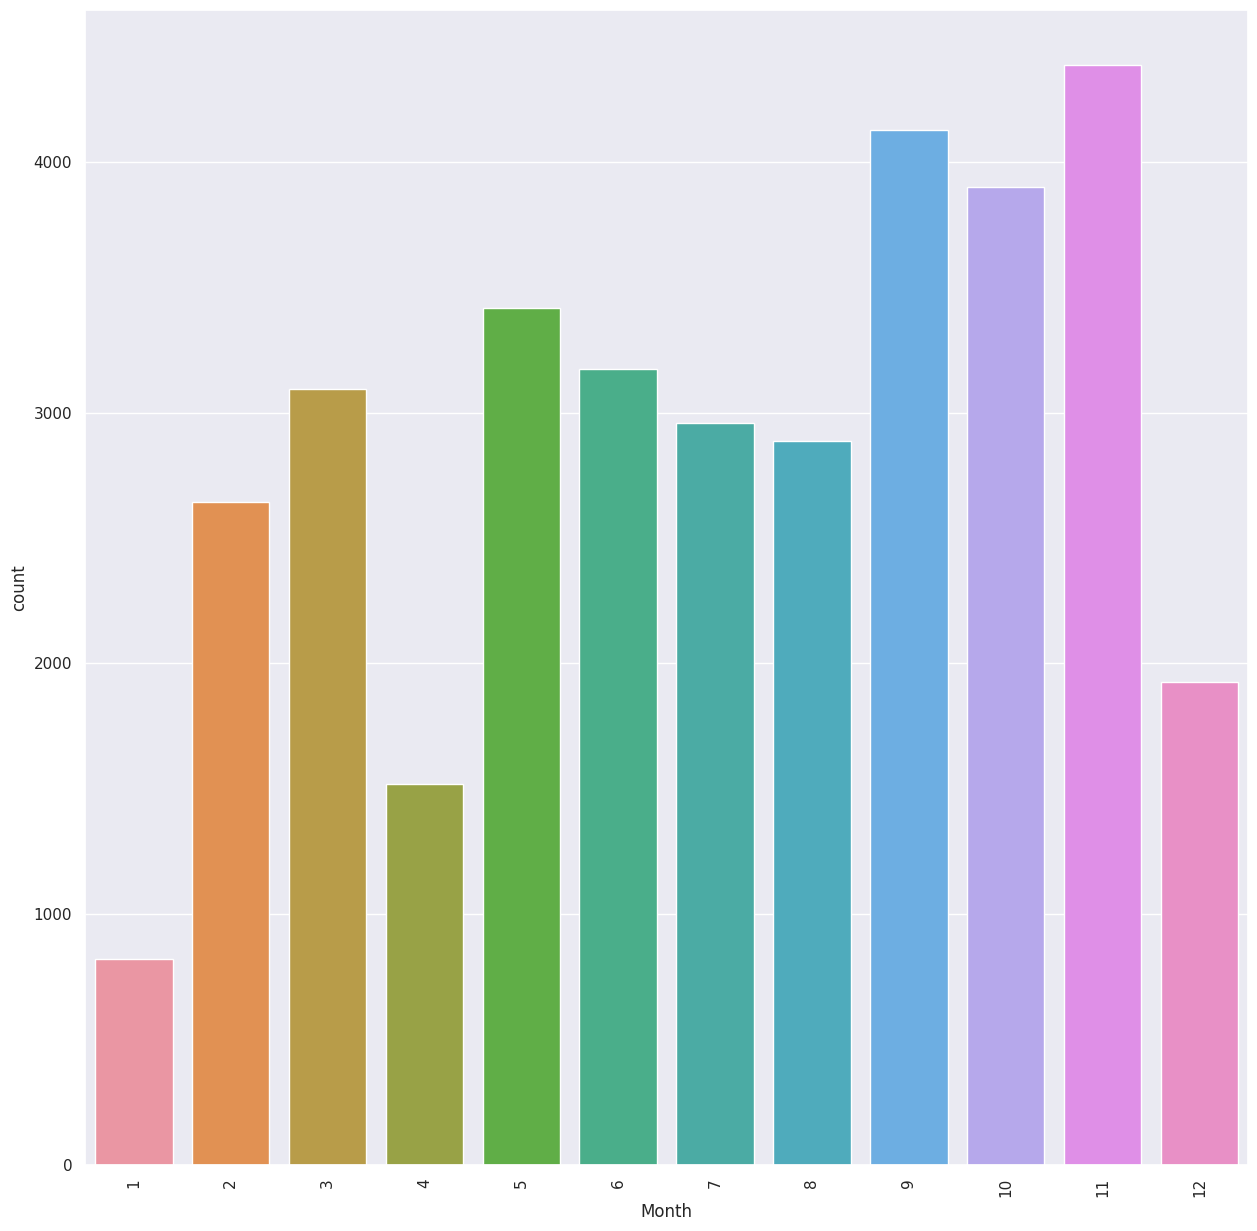

       Year  Ratio
2017  19849  56.95
2016  10292  29.53
2018   4712  13.52


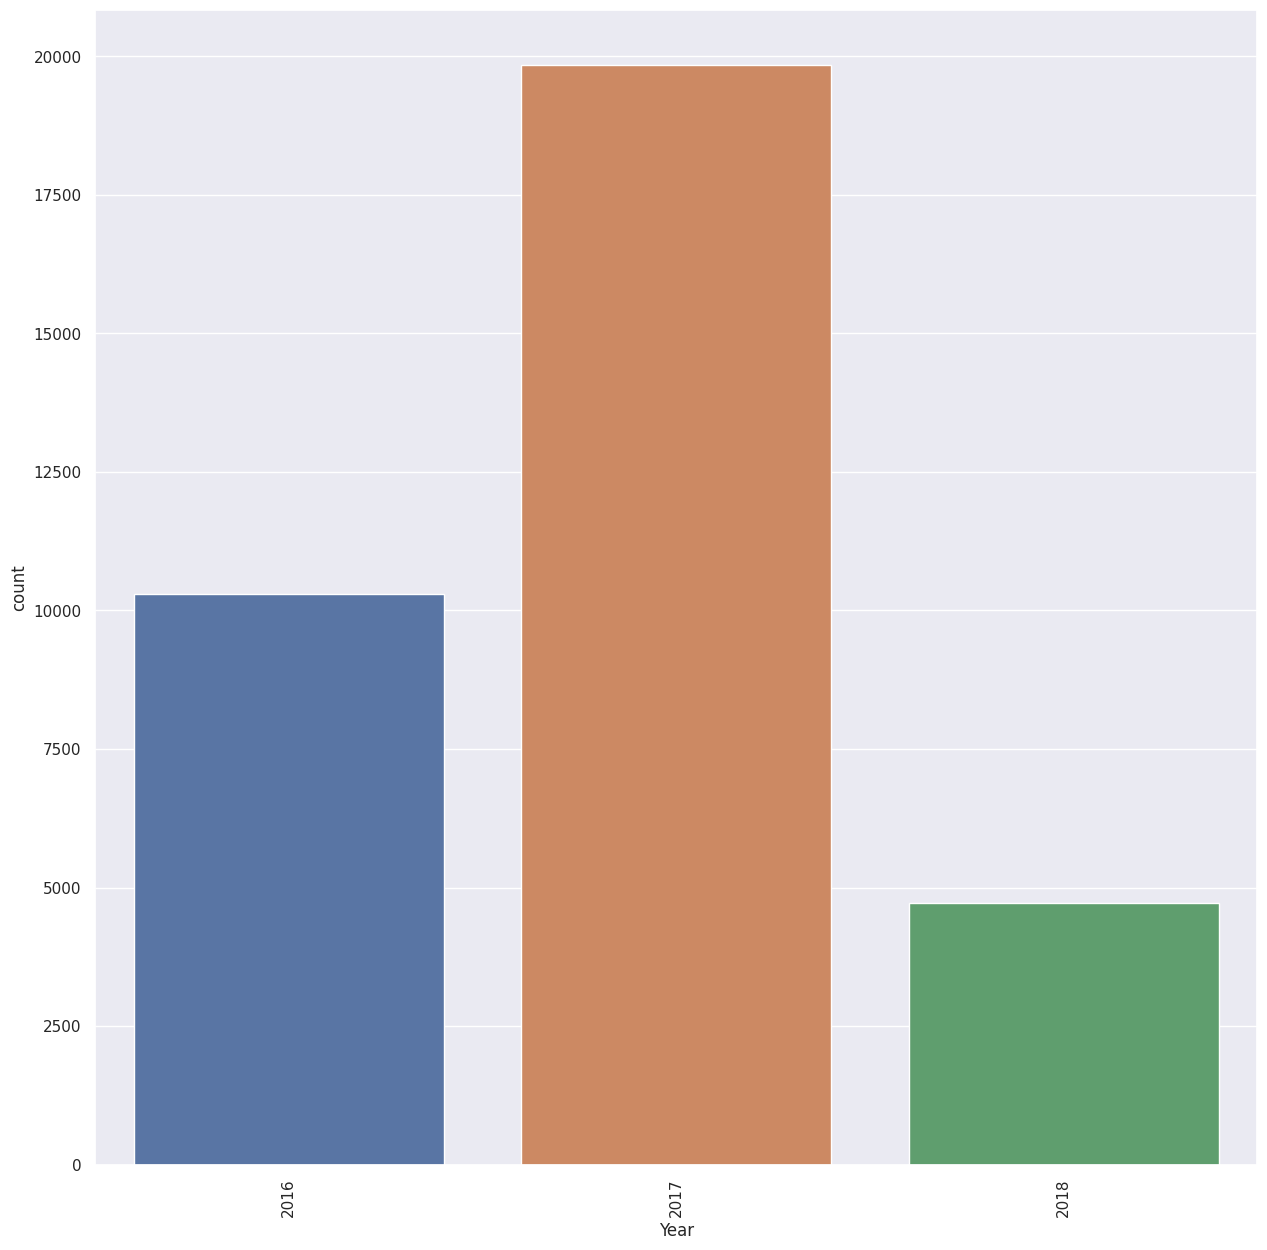

In [103]:
def cat_summary(dataframe, col_name, plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

  if plot:
    sns.countplot(x=dataframe[col_name], data=dataframe)
    plt.xticks(rotation=90)
    plt.show()


for col in cat_cols:
  cat_summary(df_copy, col, plot=True)

count   34853.00
mean        3.03
std         0.97
min         1.00
5%          2.00
10%         2.00
20%         2.00
30%         3.00
40%         3.00
50%         3.00
60%         3.00
70%         3.00
80%         4.00
90%         4.00
95%         5.00
99%         5.00
max        16.00
Name: Rooms, dtype: float64


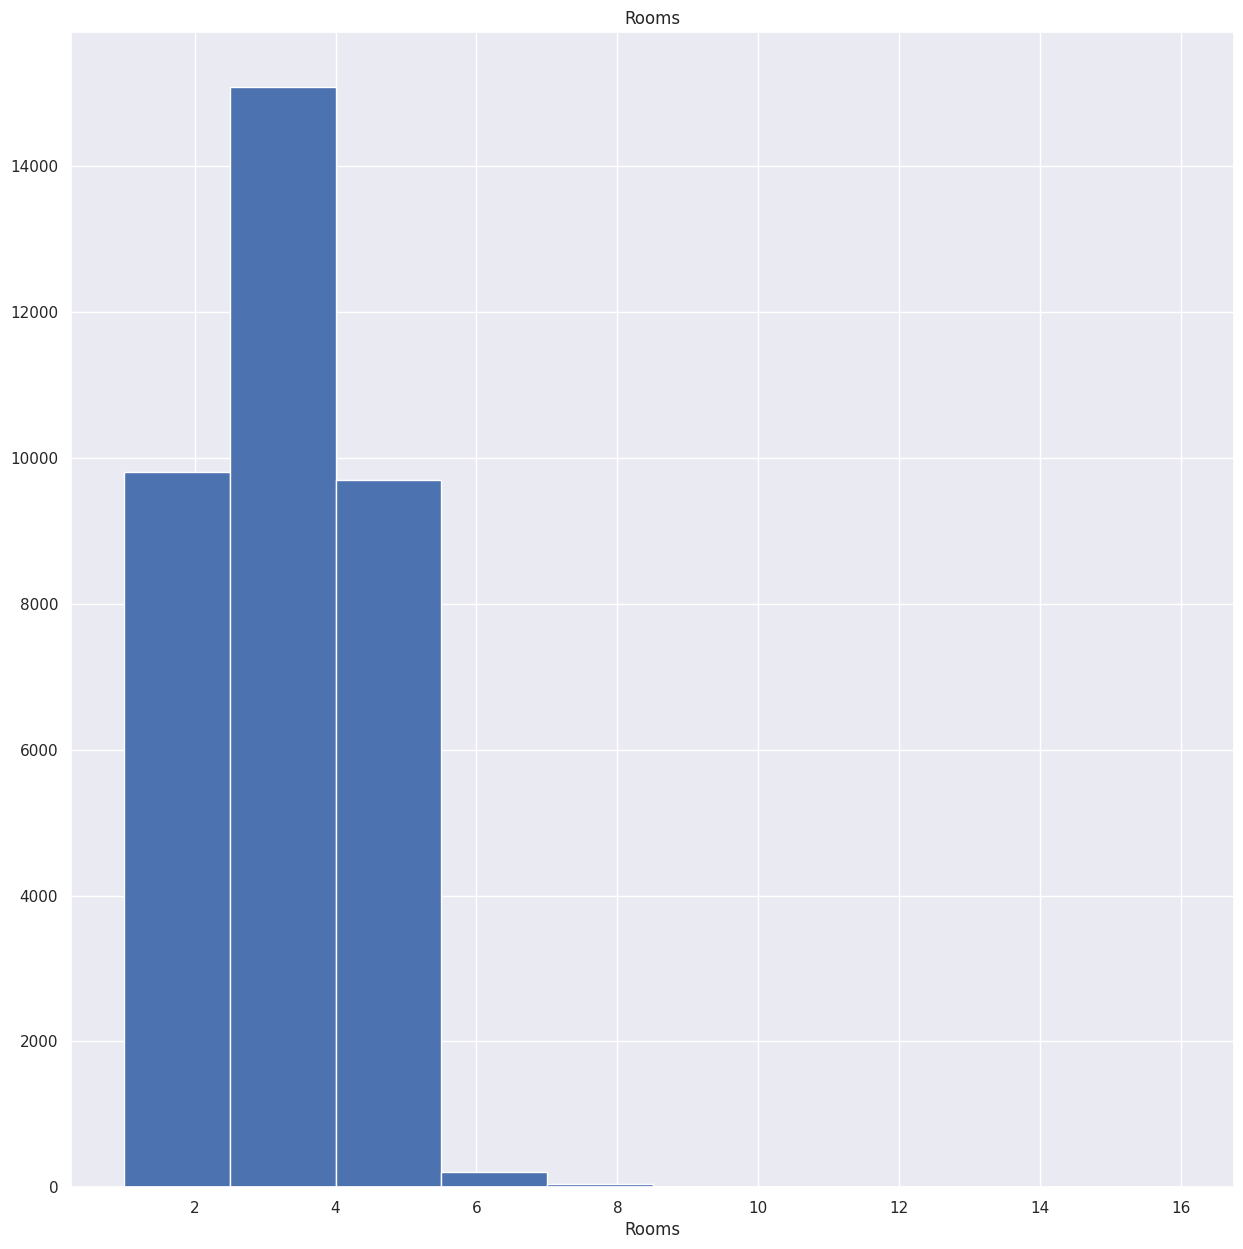

count      27244.00
mean     1050210.03
std       641492.29
min        85000.00
5%        415000.00
10%       485150.00
20%       594300.00
30%       678000.00
40%       770000.00
50%       870000.00
60%      1000000.00
70%      1200000.00
80%      1400000.00
90%      1800000.00
95%      2250000.00
99%      3400570.00
max     11200000.00
Name: Price, dtype: float64


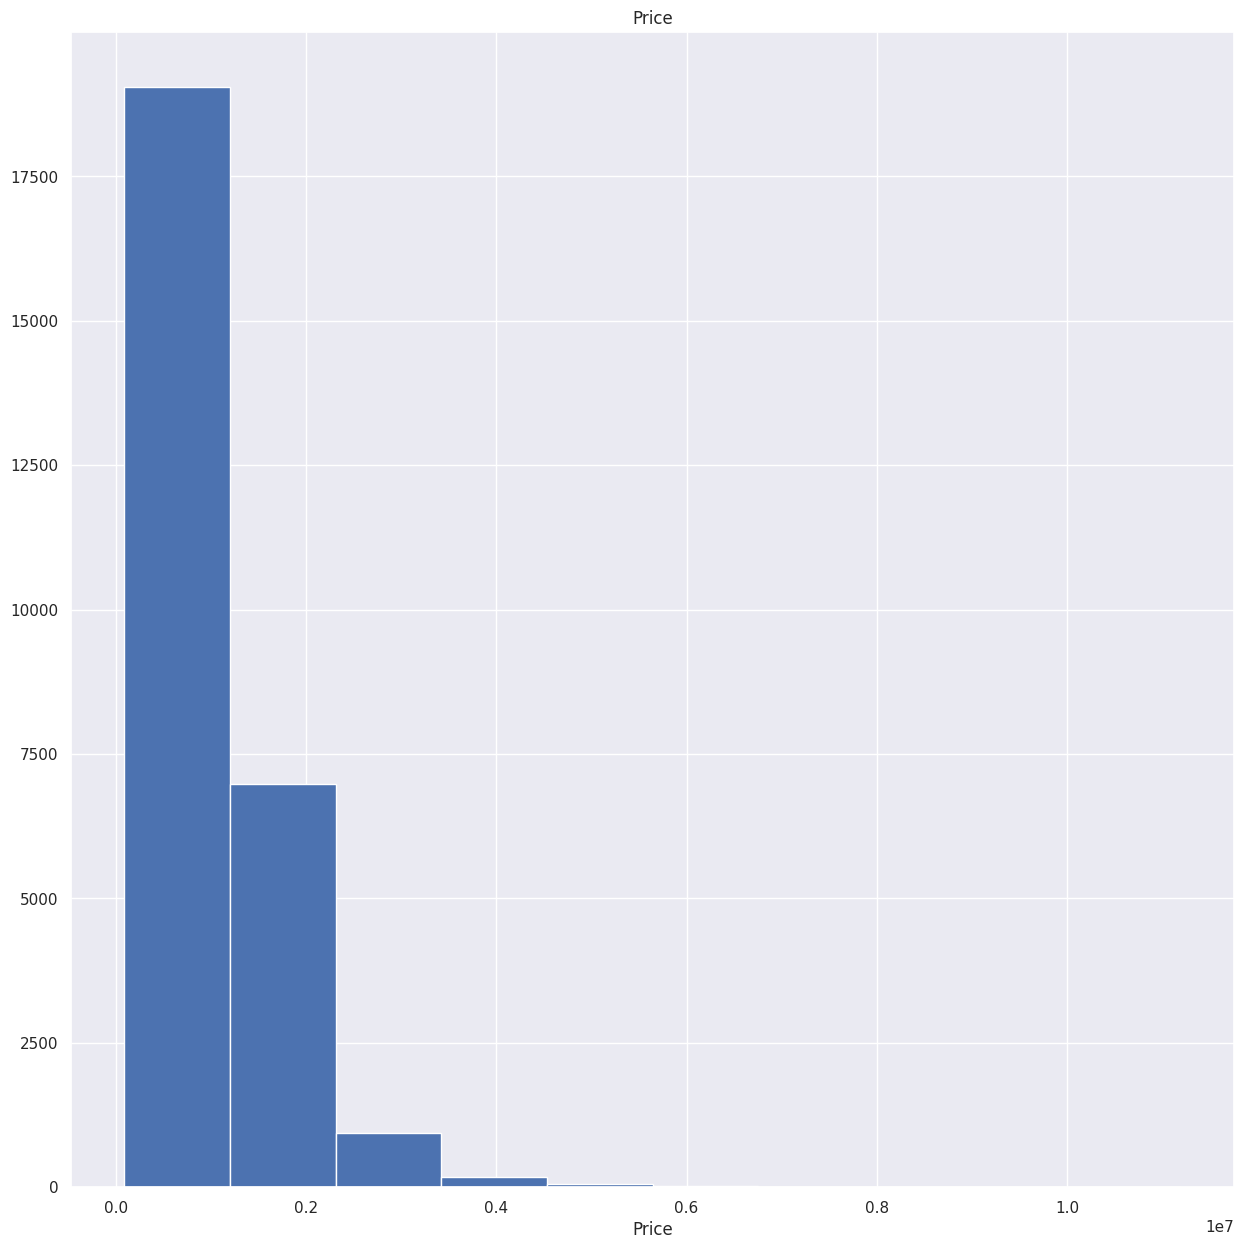

count   34853.00
mean       11.19
std         6.79
min         0.00
5%          2.70
10%         3.80
20%         5.60
30%         7.30
40%         8.50
50%        10.30
60%        11.40
70%        13.40
80%        14.80
90%        19.90
95%        24.70
99%        35.40
max        48.10
Name: Distance, dtype: float64


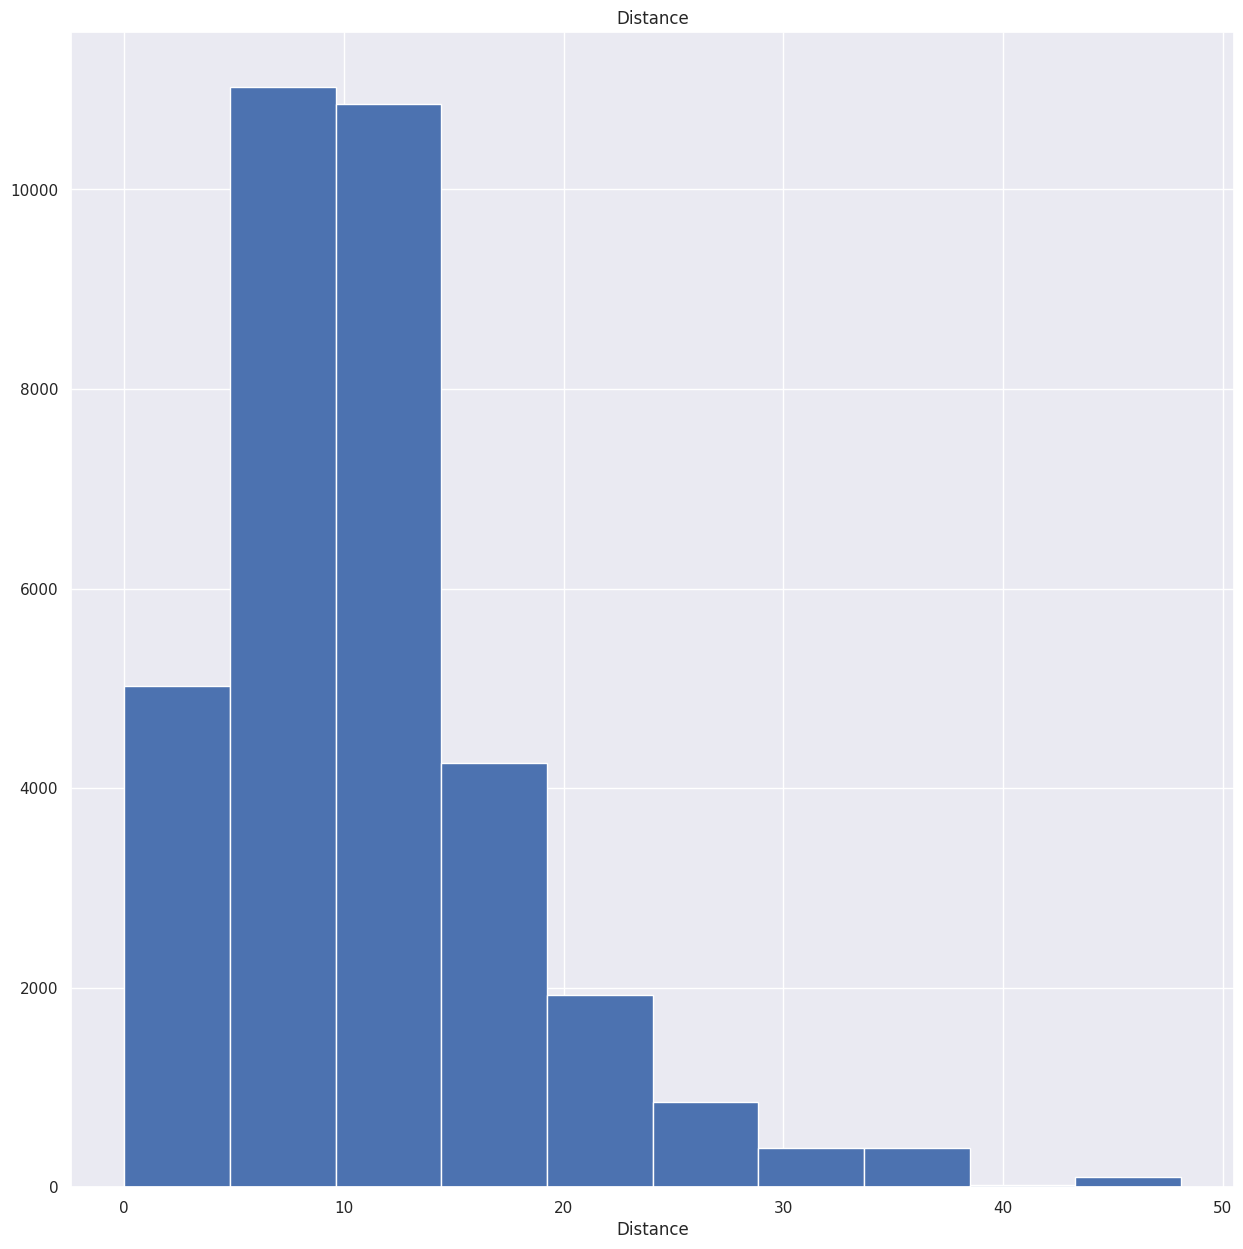

count   34853.00
mean        2.97
std         0.95
min         0.00
5%          2.00
10%         2.00
20%         2.00
30%         3.00
40%         3.00
50%         3.00
60%         3.00
70%         3.00
80%         4.00
90%         4.00
95%         4.00
99%         5.00
max        30.00
Name: Bedroom2, dtype: float64


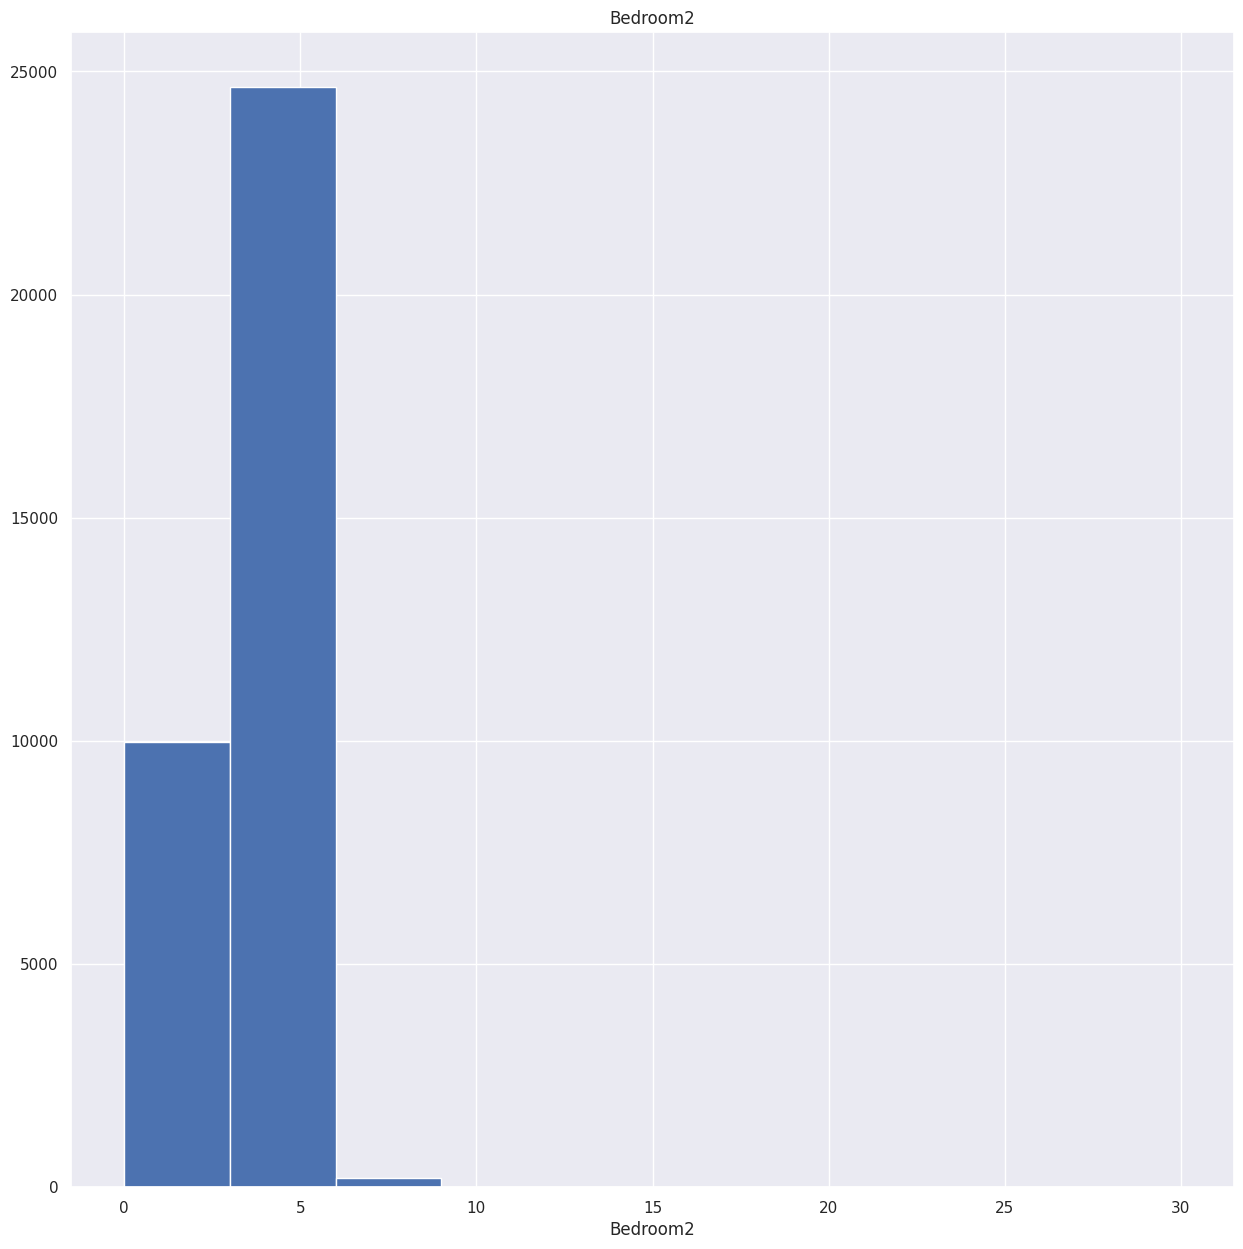

count   34853.00
mean        1.64
std         0.66
min         0.00
5%          1.00
10%         1.00
20%         1.00
30%         1.00
40%         1.00
50%         1.50
60%         2.00
70%         2.00
80%         2.00
90%         2.00
95%         3.00
99%         4.00
max        12.00
Name: Bathroom, dtype: float64


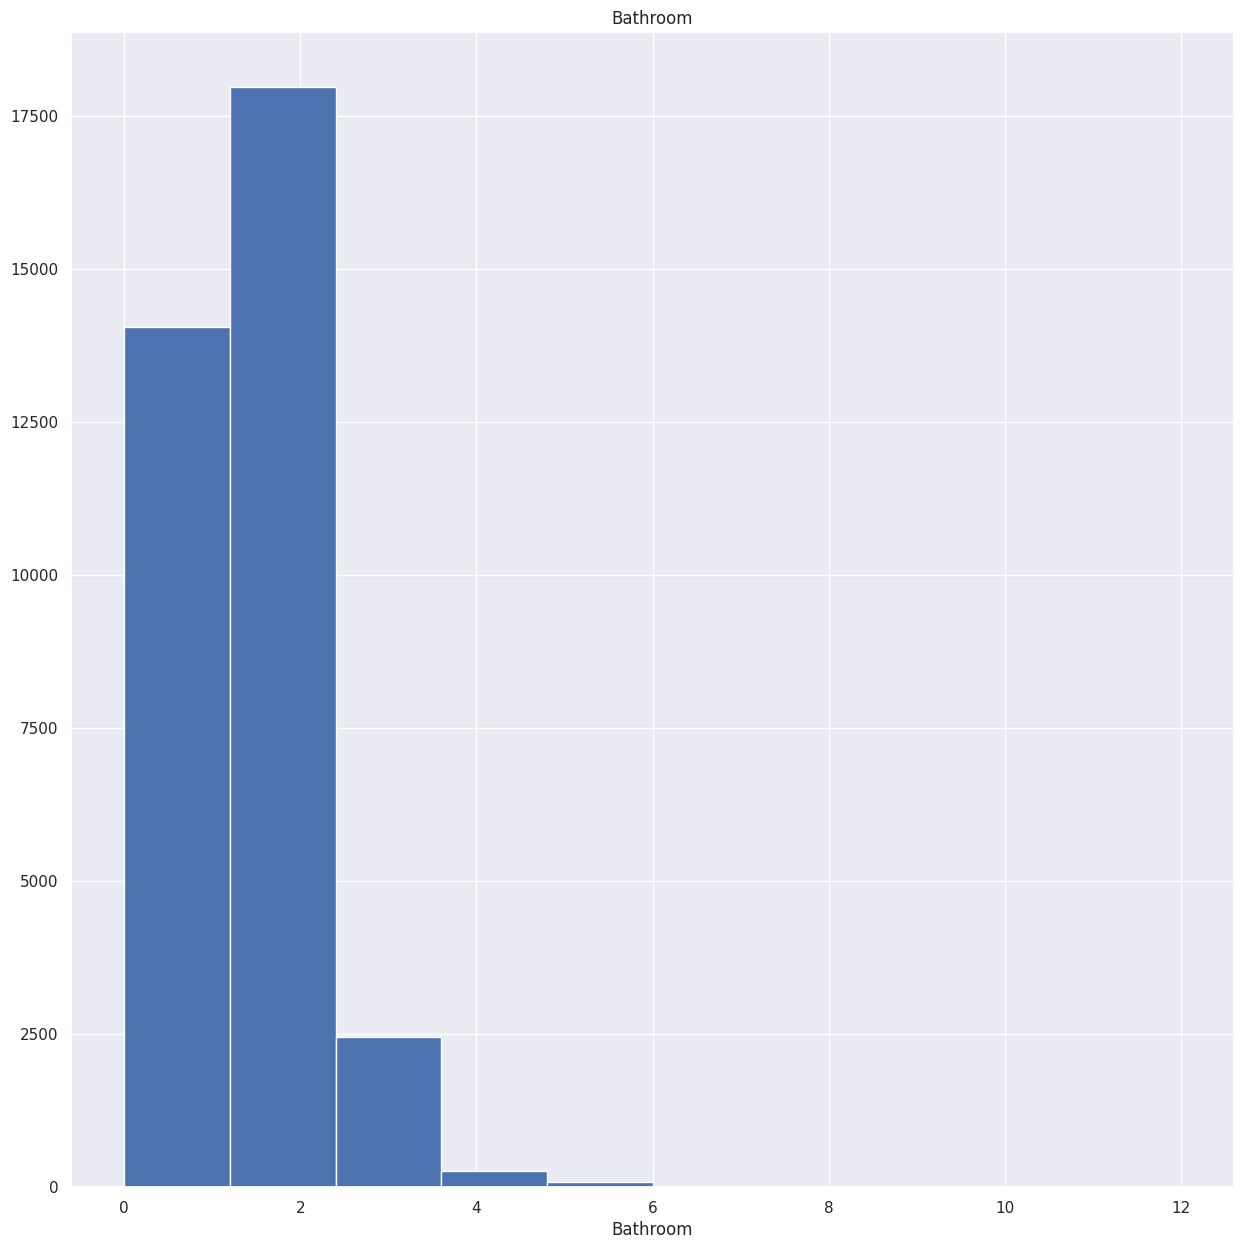

count   34853.00
mean        1.69
std         0.95
min         0.00
5%          0.00
10%         1.00
20%         1.00
30%         1.00
40%         1.00
50%         2.00
60%         2.00
70%         2.00
80%         2.00
90%         3.00
95%         3.00
99%         5.00
max        26.00
Name: Car, dtype: float64


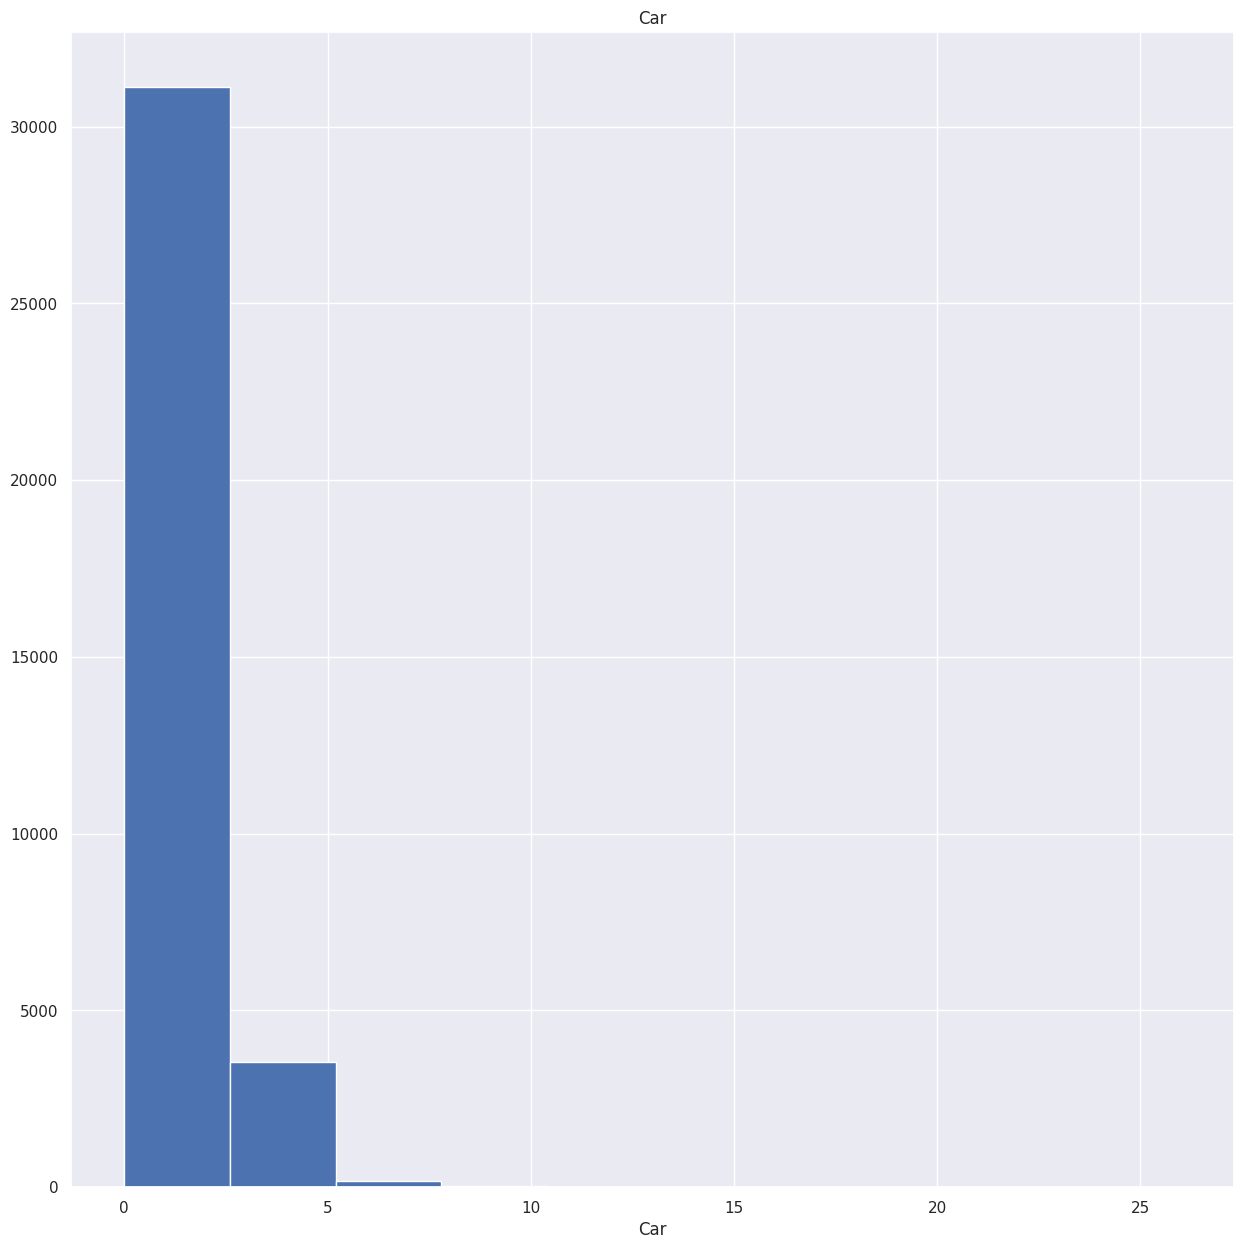

count   34853.00
mean      151.99
std       261.96
min         0.00
5%         53.00
10%        71.00
20%        90.00
30%       108.00
40%       123.00
50%       135.00
60%       150.00
70%       170.00
80%       195.00
90%       237.00
95%       284.50
99%       435.00
max     44515.00
Name: BuildingArea, dtype: float64


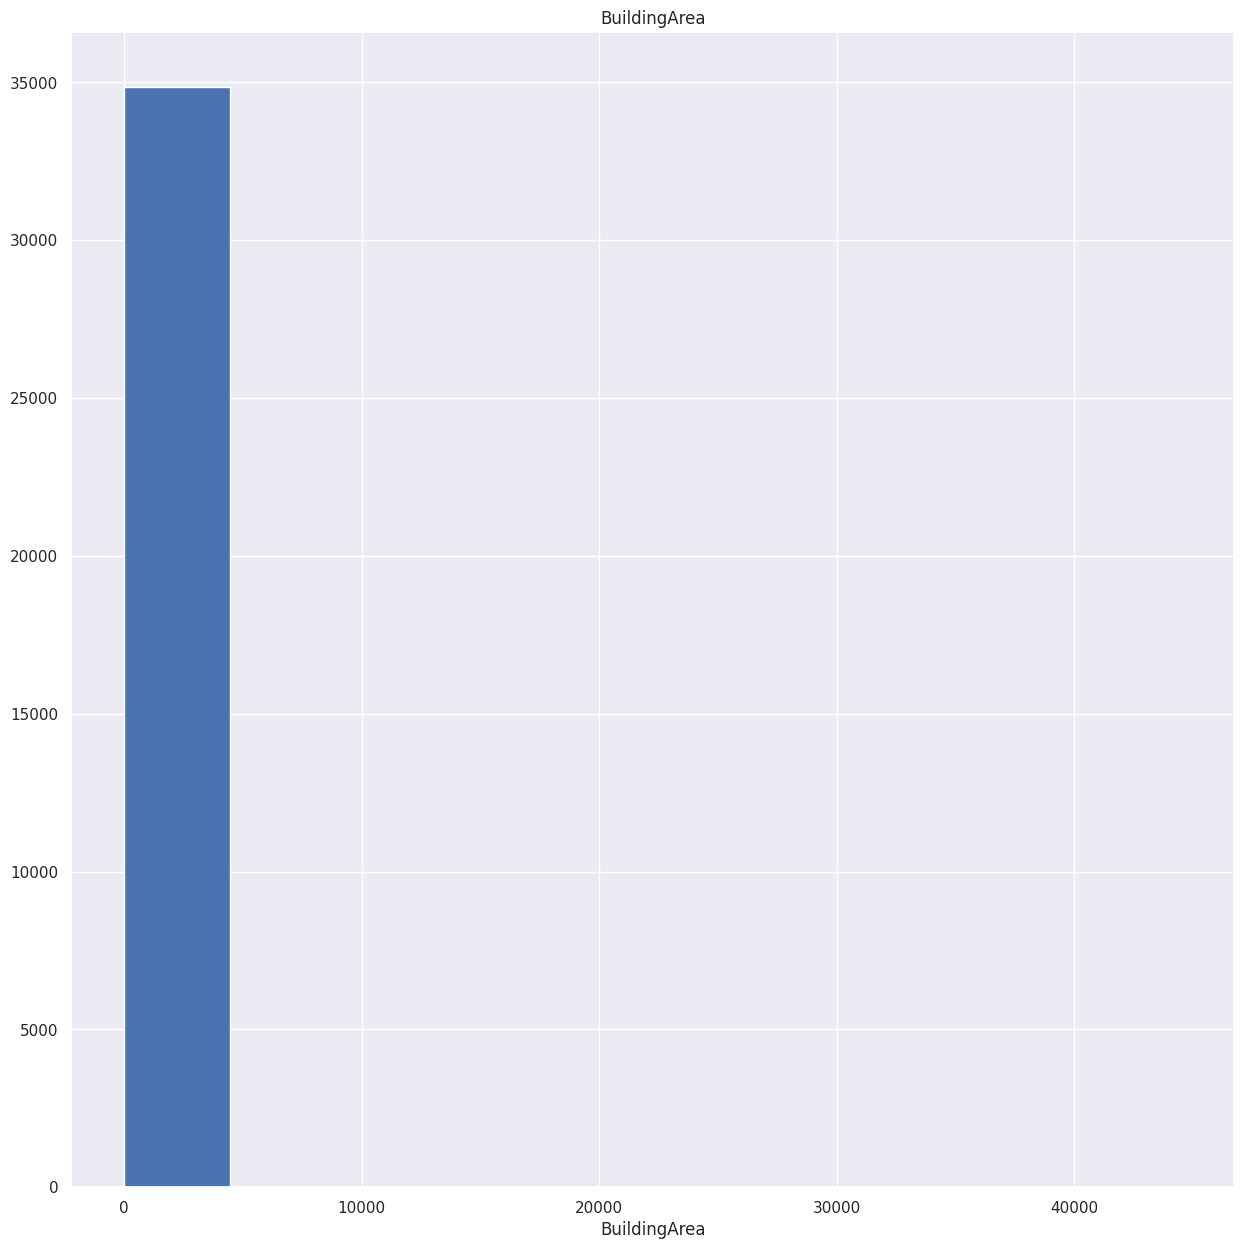

count   34853.00
mean     1964.31
std        33.66
min      1196.00
5%       1900.00
10%      1914.00
20%      1935.50
30%      1950.00
40%      1960.00
50%      1970.00
60%      1975.00
70%      1984.50
80%      1996.00
90%      2007.00
95%      2011.00
99%      2015.00
max      2106.00
Name: YearBuilt, dtype: float64


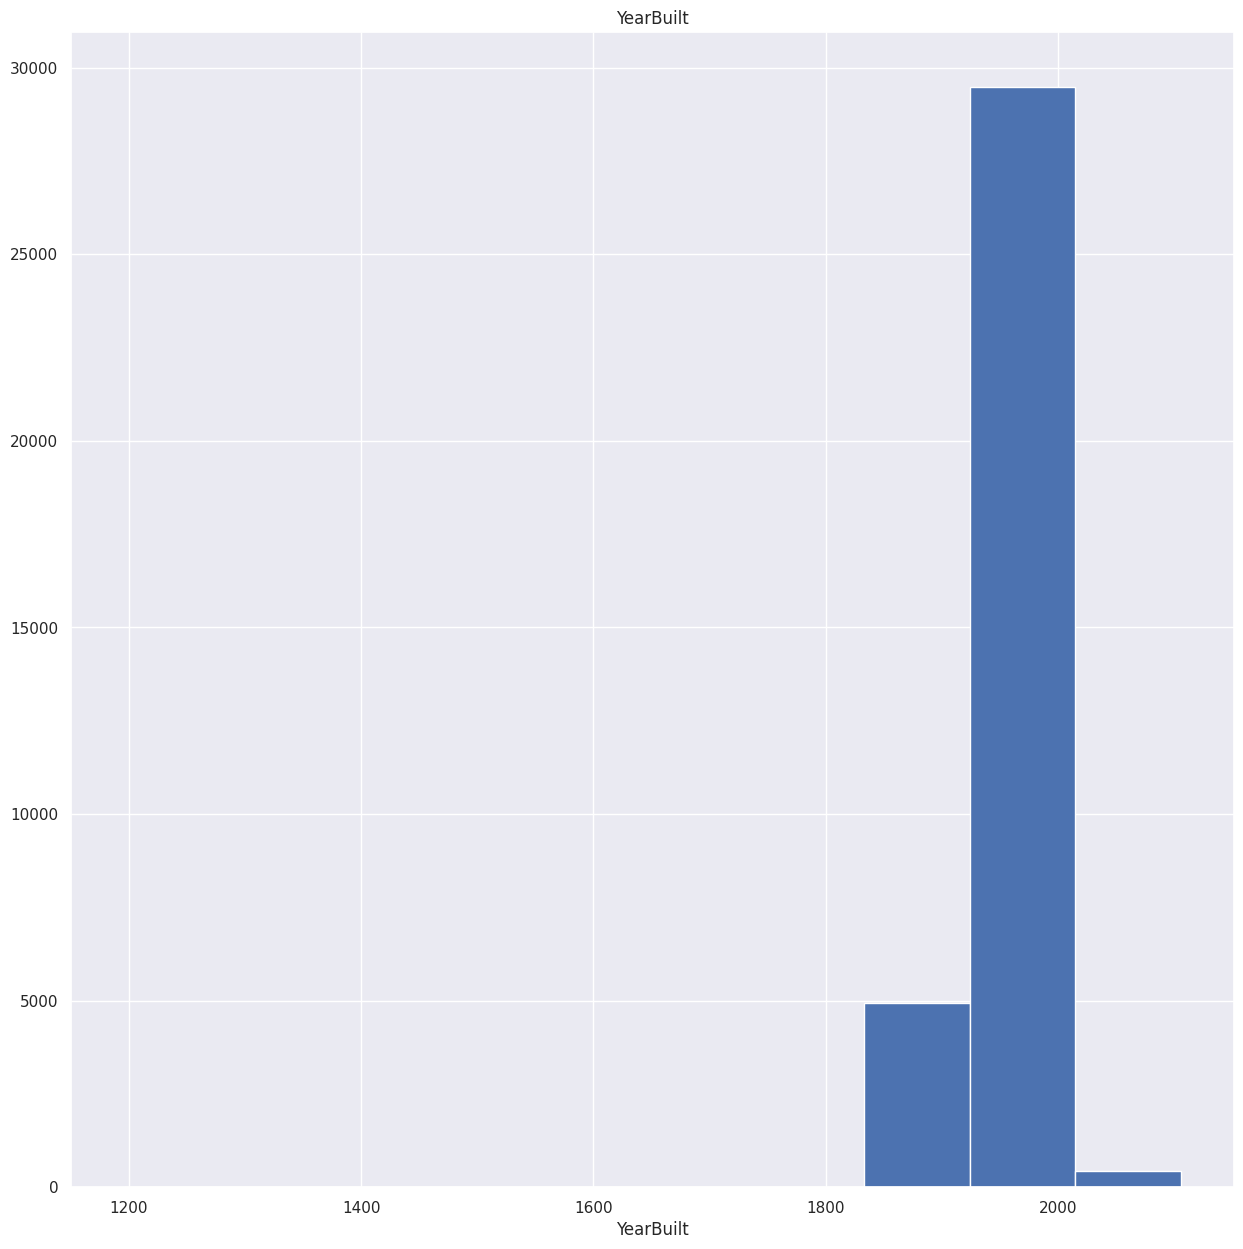

count   34853.00
mean      -37.81
std         0.09
min       -38.19
5%        -37.95
10%       -37.92
20%       -37.88
30%       -37.85
40%       -37.83
50%       -37.81
60%       -37.79
70%       -37.77
80%       -37.74
90%       -37.71
95%       -37.68
99%       -37.59
max       -37.39
Name: Lattitude, dtype: float64


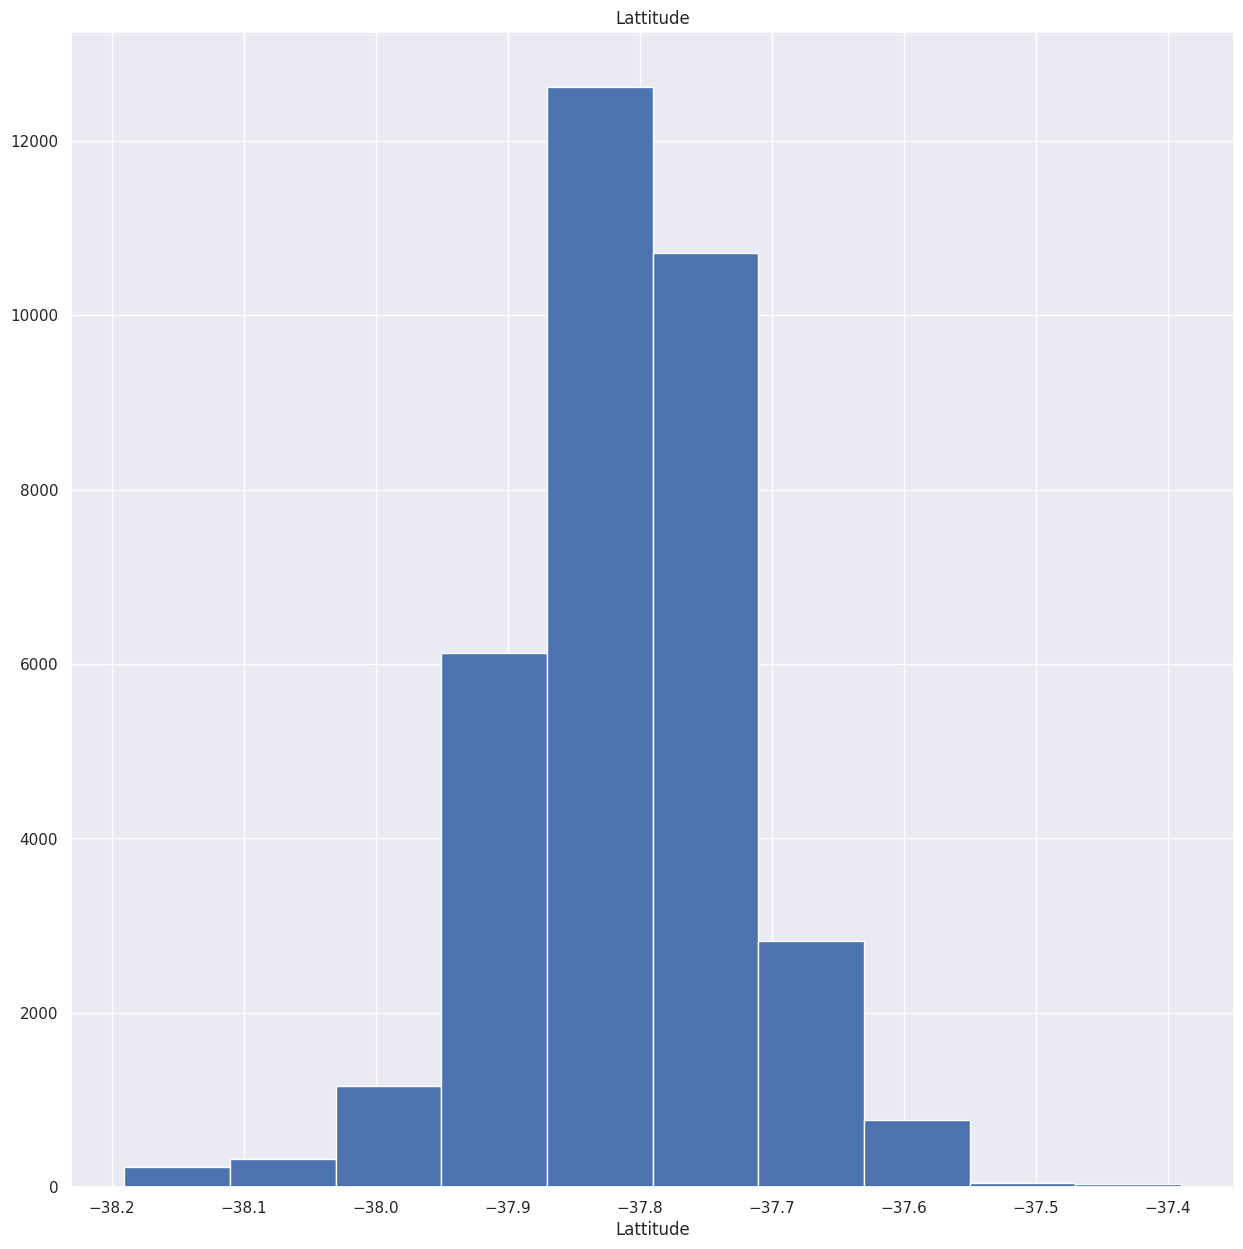

count   34853.00
mean      145.00
std         0.12
min       144.42
5%        144.81
10%       144.87
20%       144.92
30%       144.96
40%       144.99
50%       145.01
60%       145.03
70%       145.06
80%       145.09
90%       145.13
95%       145.18
99%       145.29
max       145.53
Name: Longtitude, dtype: float64


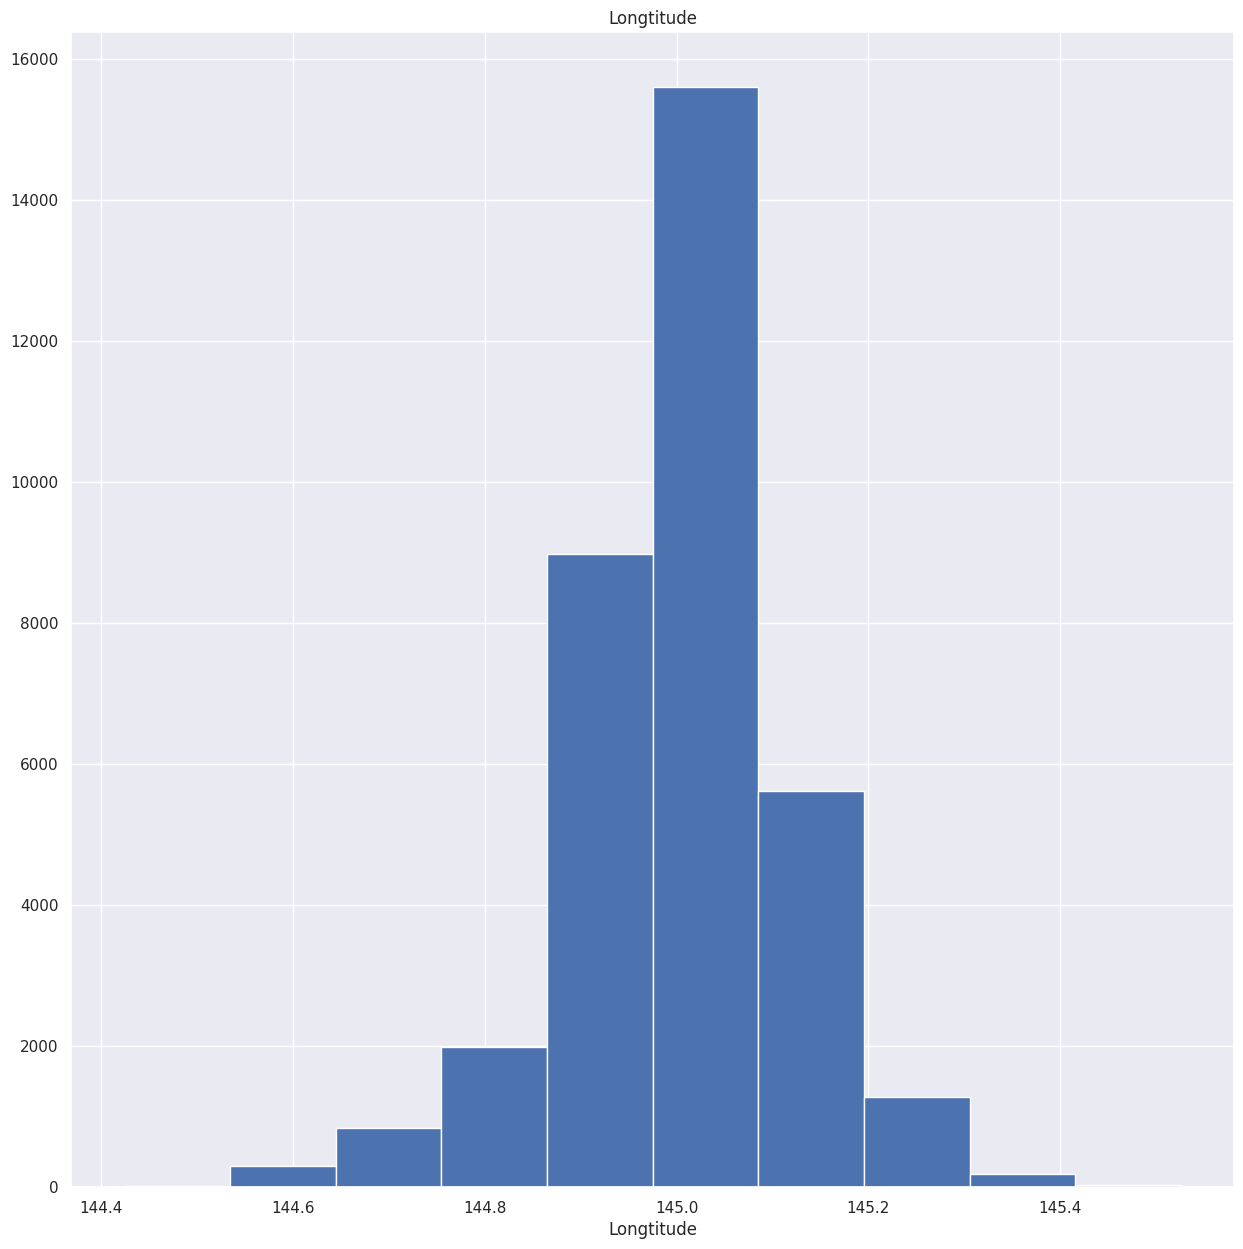

count   34853.00
mean     7572.96
std      4428.13
min        83.00
5%       2185.00
10%      2674.00
20%      3650.00
30%      4836.00
40%      5556.00
50%      6763.00
60%      7809.00
70%      8989.00
80%     10969.00
90%     14577.00
95%     15510.00
99%     21650.00
max     21650.00
Name: Propertycount, dtype: float64


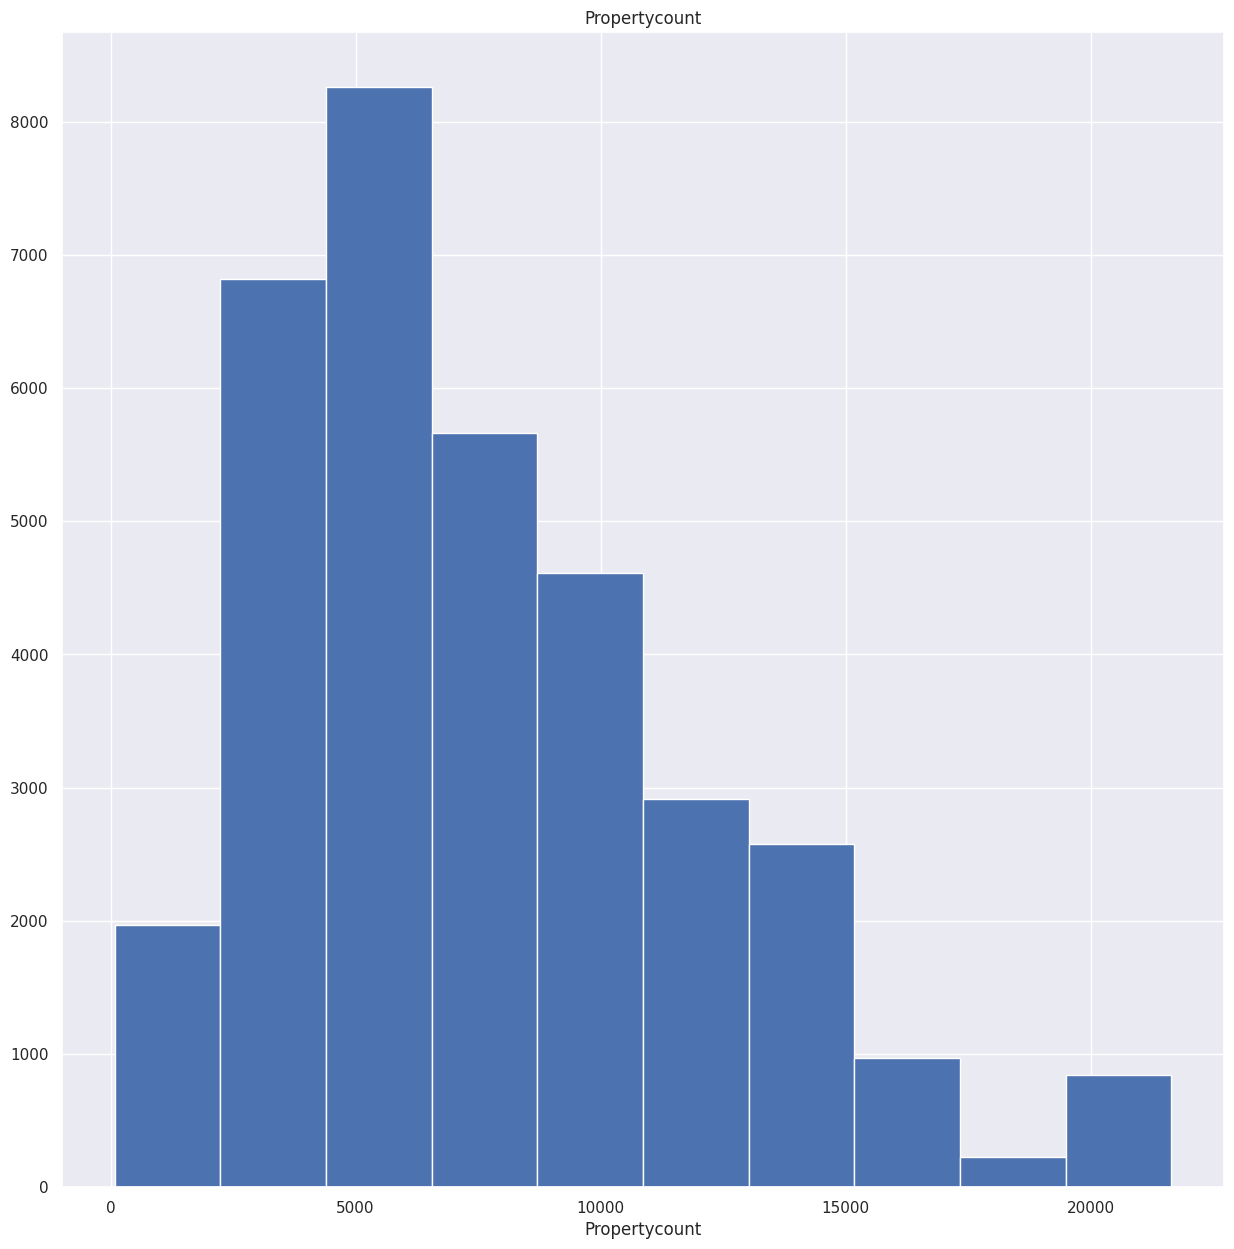

In [104]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


for col in num_cols:
    num_summary(df_copy, col, plot=True)

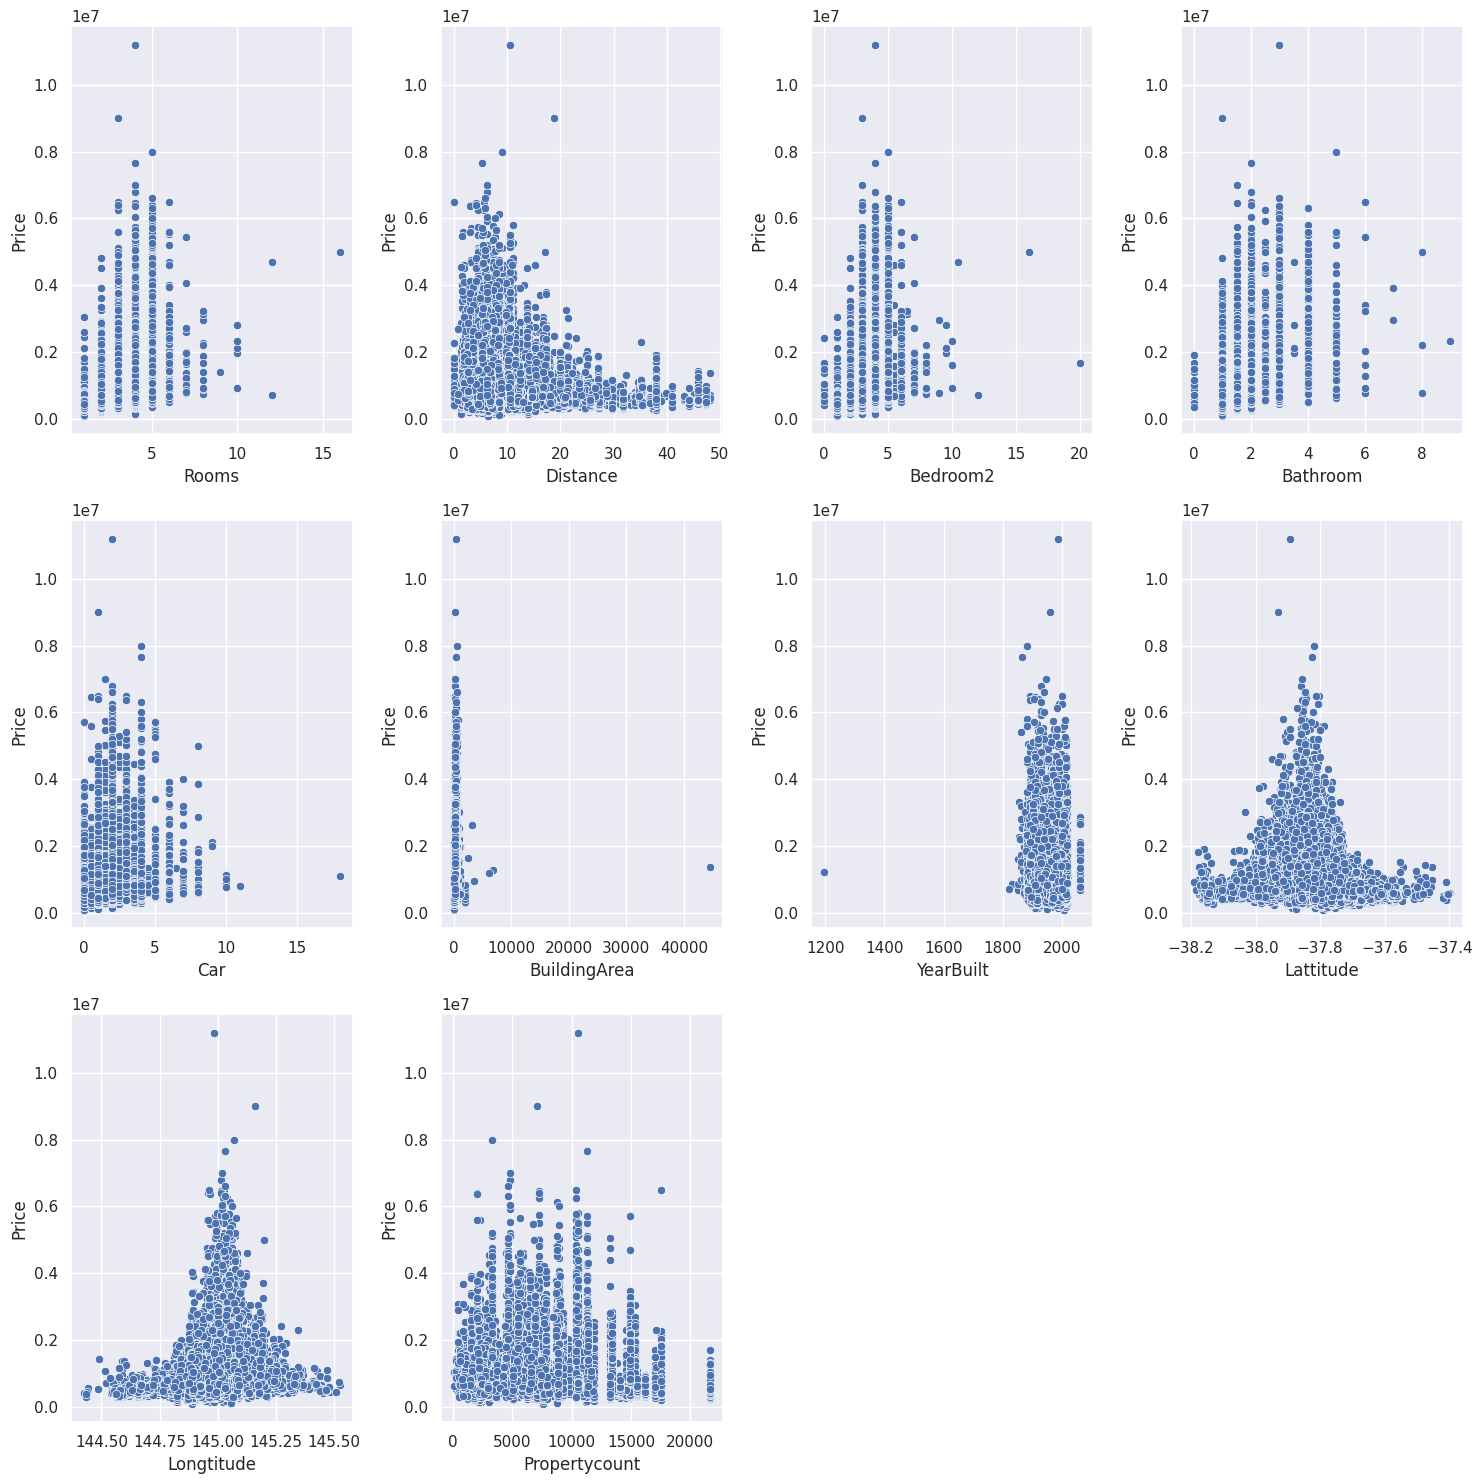

In [105]:
other_cols = [col for col in num_cols if col != target_col]

n_cols = 4
n_rows = int(np.ceil(len(other_cols) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(other_cols):
    sns.scatterplot(data=df_copy, x=col, y=target_col, ax=axes[i])

for i in range(len(other_cols), n_cols * n_rows):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [106]:
label_encoder = LabelEncoder()

for col in df_copy.columns:
  df_copy[col] = label_encoder.fit_transform(df_copy[col])

In [107]:
standard_scaler = StandardScaler()

for col in df_copy.columns:
    # Veriyi iki boyutlu hale getir
    feature = df_copy[col].values.reshape(-1, 1)
    # Veriyi ölçeklendir
    scaled_feature = standard_scaler.fit_transform(feature)
    # Ölçeklenmiş veriyi orijinal veri çerçevesine yerine koy
    df_copy[col] = scaled_feature

In [108]:
df_copy.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Bedroom2,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Month,Year
0,-1.71,-1.07,-0.64,1.41,1.65,-0.27,-1.53,-0.99,-0.97,-0.75,-0.22,-1.70,1.74,0.11,-0.20,-0.81,-0.75,0.59,-1.32
1,-1.71,-1.07,-0.64,0.40,-0.36,-1.38,-1.53,-0.99,-0.97,-0.75,-0.47,-0.00,1.74,0.13,-0.17,-0.81,-0.75,1.54,-1.32
2,-1.71,-1.07,-0.64,-0.18,-0.36,-1.38,-1.53,-0.99,-0.97,-1.83,-1.11,-1.88,1.74,0.02,-0.23,-0.81,-0.75,-1.63,-1.32
3,-1.71,-0.03,1.81,1.41,2.16,1.01,-1.53,0.02,0.55,-0.75,-0.47,-0.33,1.74,-0.03,0.01,-0.81,-0.75,-1.63,-1.32
4,-1.71,-0.03,-0.64,0.39,1.15,-1.38,-1.53,0.02,0.55,-1.83,0.18,-1.88,1.74,-0.00,-0.22,-0.81,-0.75,-1.31,0.25


4. Model Selection

In [109]:
df_copy_train = df_copy.dropna()
df_copy_test = df_copy[df_copy['Price'].isna()]

In [110]:
X = df_copy_train.drop('Price' , axis = 1)
y = df_copy_train['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
def base_models(X, y):
    print("Base Models....")
    regressors = [
        ('LSS', Lasso()),
        ('KNN', KNeighborsRegressor()),
        ("CART", DecisionTreeRegressor()),
        ("RF", RandomForestRegressor()),
        ('Ridge', Ridge()),
        ('ElasticNet', ElasticNet()),
        ('Adaboost', AdaBoostRegressor()),
        ('GBM', GradientBoostingRegressor()),
        ('XGBoost', XGBRegressor()),
        ('LightGBM', LGBMRegressor())
    ]

    for name, model in regressors:
        cv_results_mae = cross_validate(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        cv_results_mse = cross_validate(model, X, y, cv=5, scoring='neg_mean_squared_error')
        cv_results_r2 = cross_validate(model, X, y, cv=5, scoring='r2')

        mae_mean = np.abs(cv_results_mae['test_score']).mean()
        mse_mean = np.abs(cv_results_mse['test_score']).mean()
        rmse_mean = np.sqrt(np.abs(mse_mean))
        r2_mean = cv_results_r2['test_score'].mean()

        print(f"Metrics for {name}:")
        print(f"MAE: {mae_mean:.2f}")
        print(f"MSE: {mse_mean:.2f}")
        print(f"RMSE: {rmse_mean:.2f}")
        print(f"R2: {r2_mean:.2f}")
        print("--------------------")

5. Model Evaluation

In [112]:
def hyperparameter_optimization(X, y, cv=3, scoring='neg_mean_squared_error'):
    print("Hyperparameter Optimization....")
    regressors = [
        ('LSS', Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
        ('KNN', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
        ("CART", DecisionTreeRegressor(), {'max_depth': [None, 5, 10]}),
        ("RF", RandomForestRegressor(), {'n_estimators': [50, 100, 200]}),
        ('Ridge', Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
        ('ElasticNet', ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]}),
        ('Adaboost', AdaBoostRegressor(), {'n_estimators': [50, 100, 200]}),
        ('GBM', GradientBoostingRegressor(), {'n_estimators': [50, 100, 200]}),
        ('XGBoost', XGBRegressor(), {'n_estimators': [50, 100, 200]}),
        ('LightGBM', LGBMRegressor(), {'n_estimators': [50, 100, 200]})
    ]
    best_models = {}
    for name, reg, params in  regressors:
        print(f"########## {name} ##########")
        cv_results = cross_validate(reg, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(reg, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = reg.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [113]:
base_models(X, y)

Base Models....
Metrics for LSS:
MAE: 0.88
MSE: 1.00
RMSE: 1.00
R2: -0.01
--------------------
Metrics for KNN:
MAE: 0.60
MSE: 0.67
RMSE: 0.82
R2: 0.32
--------------------
Metrics for CART:
MAE: 0.58
MSE: 0.85
RMSE: 0.92
R2: 0.15
--------------------
Metrics for RF:
MAE: 0.47
MSE: 0.43
RMSE: 0.66
R2: 0.56
--------------------
Metrics for Ridge:
MAE: 0.63
MSE: 0.65
RMSE: 0.81
R2: 0.34
--------------------
Metrics for ElasticNet:
MAE: 0.88
MSE: 1.00
RMSE: 1.00
R2: -0.01
--------------------
Metrics for Adaboost:
MAE: 0.73
MSE: 0.72
RMSE: 0.85
R2: 0.27
--------------------
Metrics for GBM:
MAE: 0.50
MSE: 0.46
RMSE: 0.68
R2: 0.54
--------------------
Metrics for XGBoost:
MAE: 0.46
MSE: 0.41
RMSE: 0.64
R2: 0.59
--------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1914

In [115]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## LSS ##########
neg_mean_squared_error (Before): -1.0006
neg_mean_squared_error (After): -0.7233
LSS best params: {'alpha': 0.1}

########## KNN ##########
neg_mean_squared_error (Before): -0.6794
neg_mean_squared_error (After): -0.6554
KNN best params: {'n_neighbors': 7}

########## CART ##########
neg_mean_squared_error (Before): -0.8857
neg_mean_squared_error (After): -0.5742
CART best params: {'max_depth': 10}

########## RF ##########
neg_mean_squared_error (Before): -0.4574
neg_mean_squared_error (After): -0.4554
RF best params: {'n_estimators': 200}

########## Ridge ##########
neg_mean_squared_error (Before): -0.655
neg_mean_squared_error (After): -0.655
Ridge best params: {'alpha': 10.0}

########## ElasticNet ##########
neg_mean_squared_error (Before): -1.0006
neg_mean_squared_error (After): -0.6672
ElasticNet best params: {'alpha': 0.1, 'l1_ratio': 0.25}

########## Adaboost ##########
neg_mean_squared_error (Before): -0.7314
neg_mea